## 

# 0.0. Imports

In [1]:
import inflection
import pickle
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import scikitplot               as skplt
import sklearn.linear_model     as lm
import sklearn.preprocessing    as pp
import sklearn.naive_bayes      as nb
import xgboost                  as xgb
import lightgbm                 as lgbm
import imblearn.combine         as c

from IPython.core.display       import HTML
from matplotlib                 import pyplot           as plt
from sklearn                    import model_selection  as ms
from sklearn                    import ensemble         as en
from sklearn                    import neighbors        as nh

from sklearn.model_selection    import StratifiedKFold

from sklearn.metrics            import precision_score, recall_score, accuracy_score

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

# 0.1. Helper Function

In [3]:
from numpy import true_divide


def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

def precision_at_k(data, k=200):
    # Reset Index
    data = data.reset_index(drop=True)

    # Create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k=200):
    # Reset Index
    data = data.reset_index(drop=True)

    # Create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']

def cross_validation(model, x_train, y_train, k, data, verbose=True):
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    precision_k_list = []
    recall_k_list = []
    accuracy_list = []

    for i, (train_cv, val_cv) in enumerate(kfold.split(x_train, y_train), 1):
        if verbose:
            print(f'Fold Number {i}/{k}')
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k=20000)
        precision_k_list.append(precision_k)
        
        recall_k = recall_at_k(data, k=20000)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)

        accuracy = accuracy_score(y_val_fold, yhat_1)
        accuracy_list.append(accuracy)

    df = pd.DataFrame({
        'Model Name': [type(model).__name__],
        'Accuracy Mean': [np.mean(accuracy_list).round(4)],
        'Precision Mean': [np.mean(precision_list).round(4)],
        'Precision STD': [np.std(precision_list).round(4)],
        'Recall Mean': [np.mean(recall_list).round(4)],
        'Recall STD': [np.std(recall_list).round(4)],
        'Precision@K Mean': [np.mean(precision_k_list).round(4)], 
        'Precision@K STD': [np.std(precision_k_list).round(4)],
        'Recall@K Mean': [np.mean(recall_k_list).round(4)], 
        'Recall@K STD': [np.std(recall_k_list).round(4)]
    })

    return df

jupyter_settings()

# 0.2. Loadind Dataset

In [4]:
df_raw = pd.read_csv(r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação\Datasets\train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [7]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Rename Columns
df1.columns = cols_new

In [8]:
split_data = np.random.rand(len(df1)) < 0.80
train_data = df1[split_data]
future_test = df1[~split_data]

df1 = train_data.copy()

## 1.2. Data Dimensions

In [9]:
print(f'Number os Rows: {df1.shape[0]}')
print(f'Number os Columns: {df1.shape[1]}')

Number os Rows: 304970
Number os Columns: 12


## 1.3. Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1. Numerical Attributes

In [13]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
d2 = pd.DataFrame(num_attributes.apply(min)).T 
d3 = pd.DataFrame(num_attributes.apply(max)).T 
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381107.0,381106.0,190669.436361,190795.5,110033.009176,-0.002123,-1.200038
1,age,20.0,85.0,65.0,38.817385,36.0,15.501881,0.671387,-0.567013
2,driving_license,0.0,1.0,1.0,0.997826,1.0,0.046575,-21.377362,454.994575
3,region_code,0.0,52.0,52.0,26.381710,28.0,13.227440,-0.115247,-0.866018
4,previously_insured,0.0,1.0,1.0,0.458380,0.0,0.498265,0.167063,-1.972103
5,annual_premium,2630.0,540165.0,537535.0,30576.468105,31678.5,17199.075622,1.732297,33.857601
6,policy_sales_channel,1.0,163.0,162.0,112.068210,133.0,54.176103,-0.901377,-0.967697
7,vintage,10.0,299.0,289.0,154.273820,154.0,83.659990,0.003414,-1.200551
8,response,0.0,1.0,1.0,0.122166,0.0,0.327478,2.307552,3.324818


# 2.0. Feature Engineering

In [14]:
df2 = df1.copy()

In [15]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1


In [16]:
# Vehicle Age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# Vejicle Demage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0. Data Filtering

In [17]:
df3 = df2.copy()

# 4.0. Exploratory Data Analysis (EDA)

In [18]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Age

<Axes: xlabel='age', ylabel='Count'>

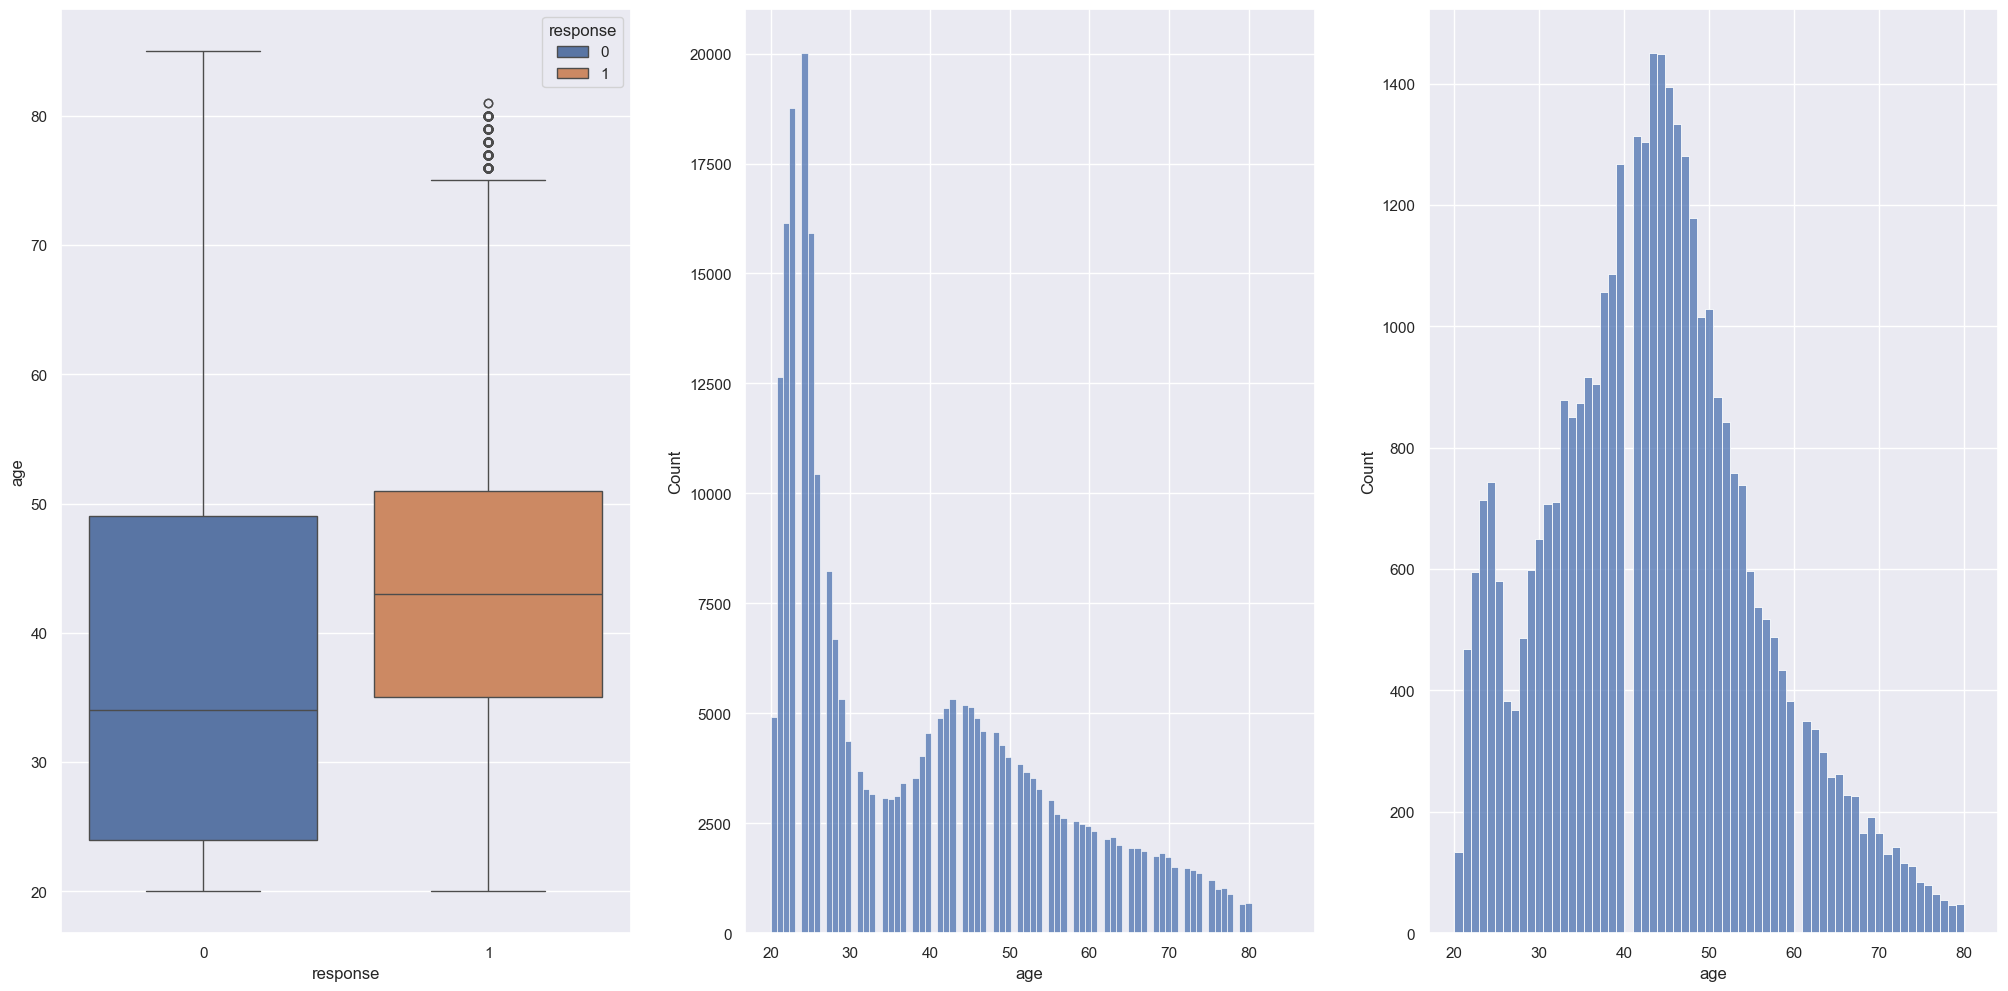

In [19]:
# Age
plt.subplot(1, 3, 1)
sns.boxplot(x='response', y='age', data=df4, hue='response')

plt.subplot(1, 3, 2)
aux00 = df4[df4['response'] == 0]['age']
sns.histplot(aux00)

plt.subplot(1, 3, 3)
aux01 = df4[df4['response'] == 1]['age']
sns.histplot(aux01)

### 4.1.3. Annual Premium

<Axes: xlabel='annual_premium', ylabel='Count'>

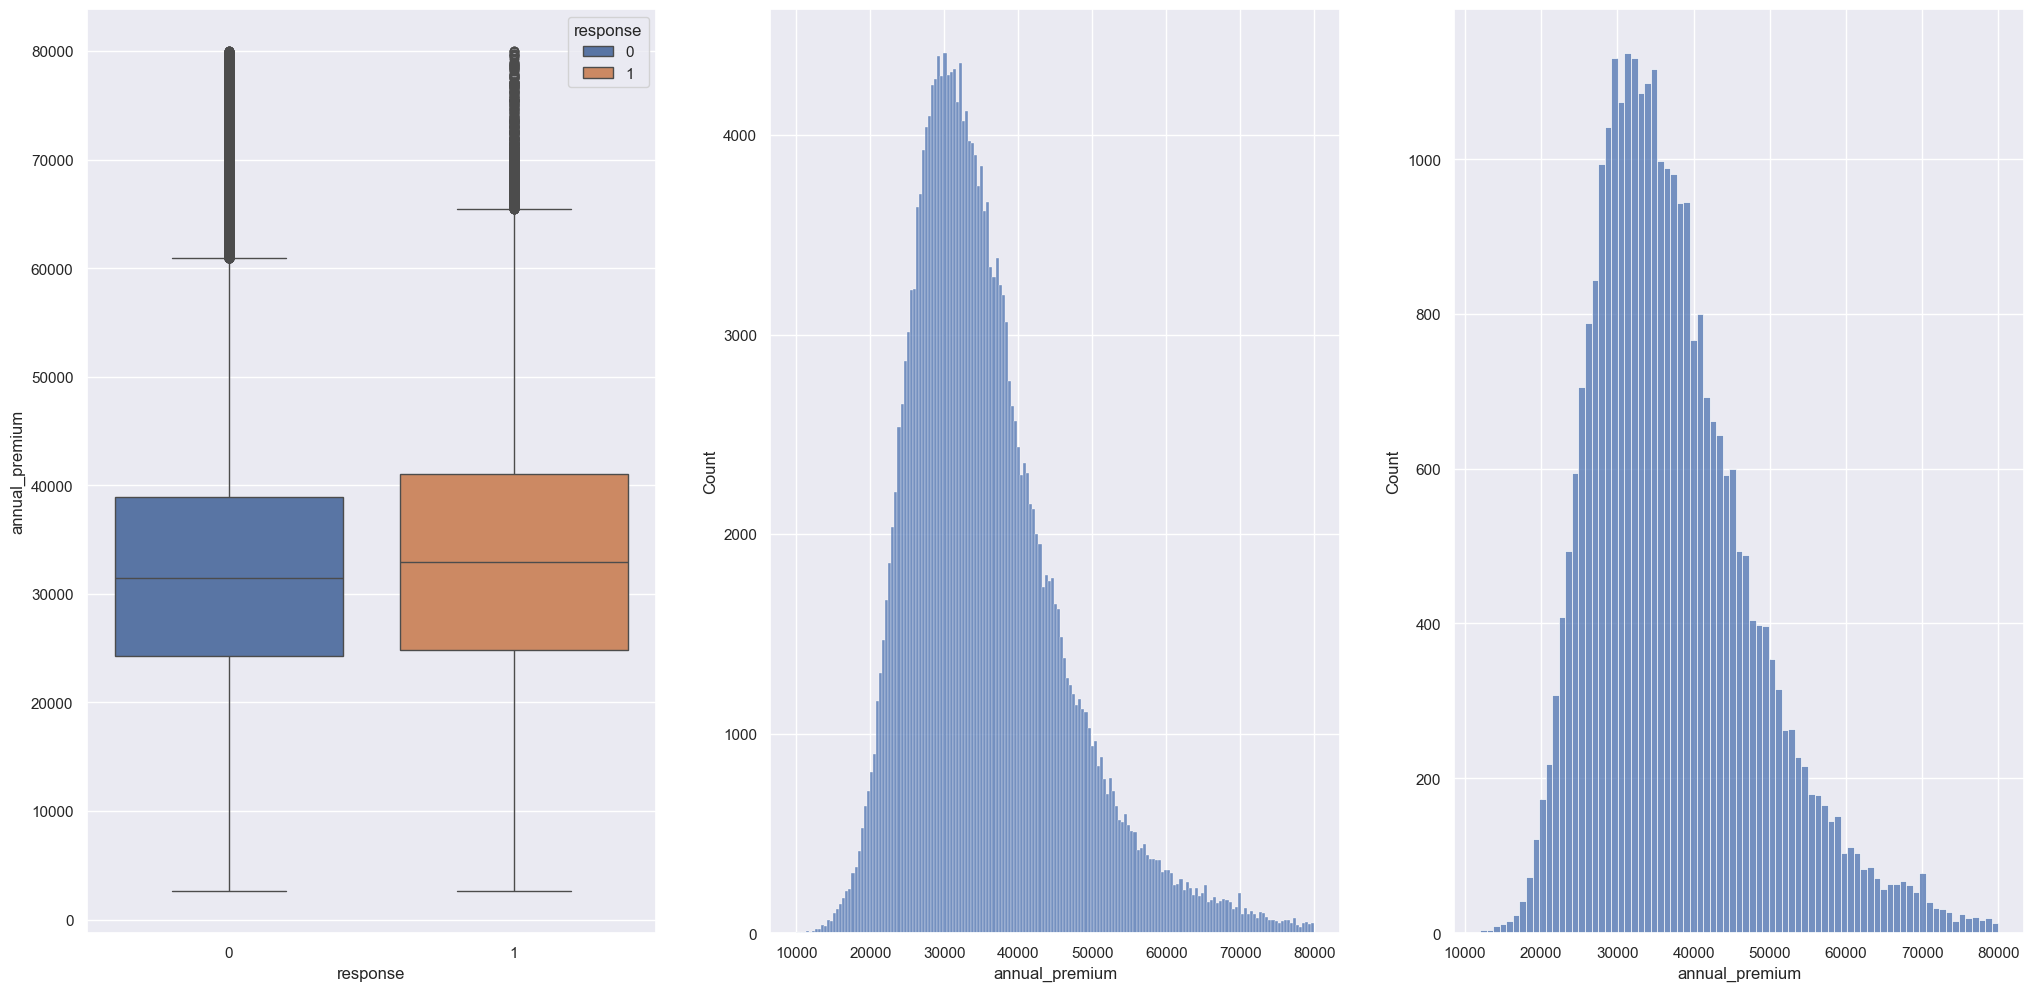

In [20]:
# Annual Premium
aux0 = df4[df4['annual_premium'] < 80000]

plt.subplot(1, 3, 1)
sns.boxplot(x='response', y='annual_premium', data=aux0, hue='response')

# Filter
aux1 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

plt.subplot(1, 3, 2)
aux00 = aux1[aux1['response'] == 0]['annual_premium']
sns.histplot(aux00)

plt.subplot(1, 3, 3)
aux01 = aux1[aux1['response'] == 1]['annual_premium']
sns.histplot(aux01)

### 4.1.4. Driving License

In [21]:
# Driving Livense
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
#sns.barplot(x='response', y='driving_license', data=aux, hue='response')

aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,267081,0.87767
1,1,37226,0.12233


### 4.1.5. Region Code

<Axes: xlabel='region_code', ylabel='id'>

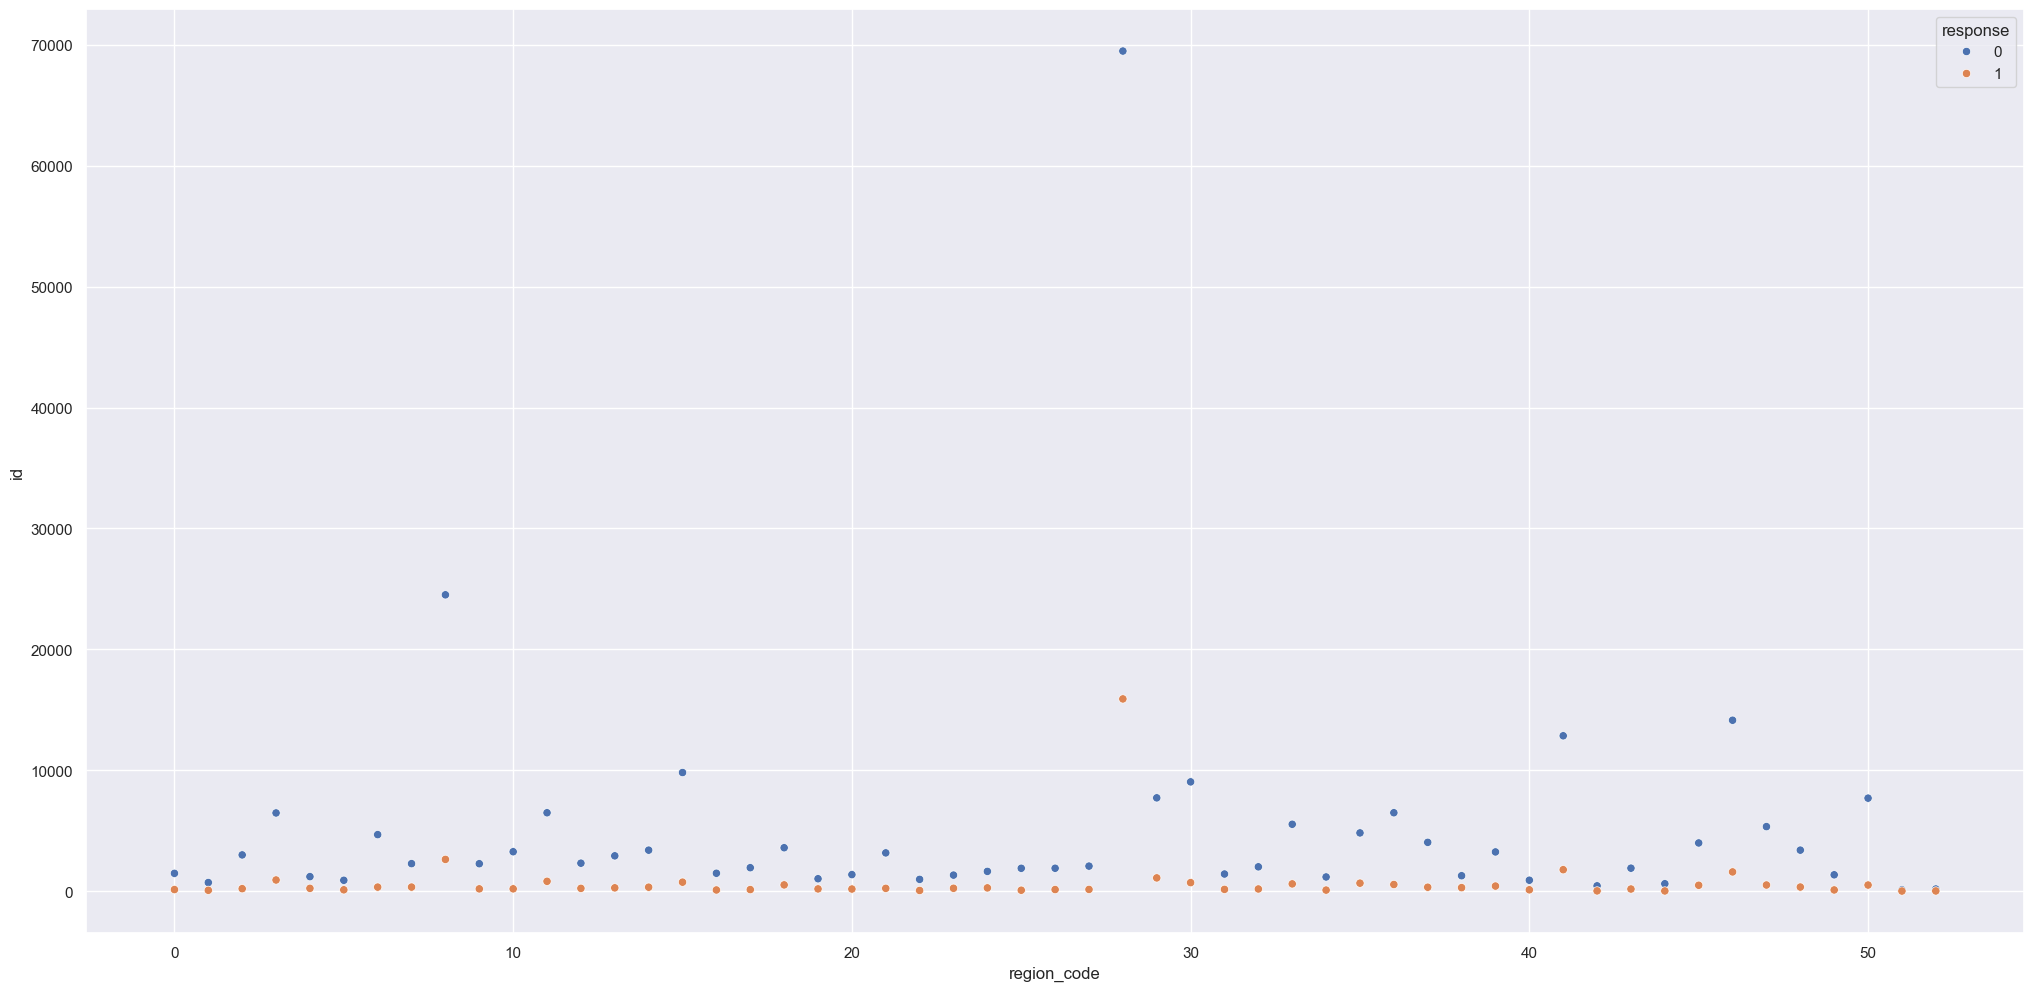

In [22]:
# Region Code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', data=aux, hue='response')

### 4.1.6. Previously Insured

In [23]:
# Previously Insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.775170,0.224830
1,0.999142,0.000858


### 4.1.7. Vehicle Age

In [24]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_year,0,0.434249
1,below_1_year,0,0.413654
2,between_1_2_year,1,0.090930
3,over_2_years,0,0.029931
4,below_1_year,1,0.018861
5,over_2_years,1,0.012375


### 4.1.8. Policy Sales Channel - Stacked Percentage Bar

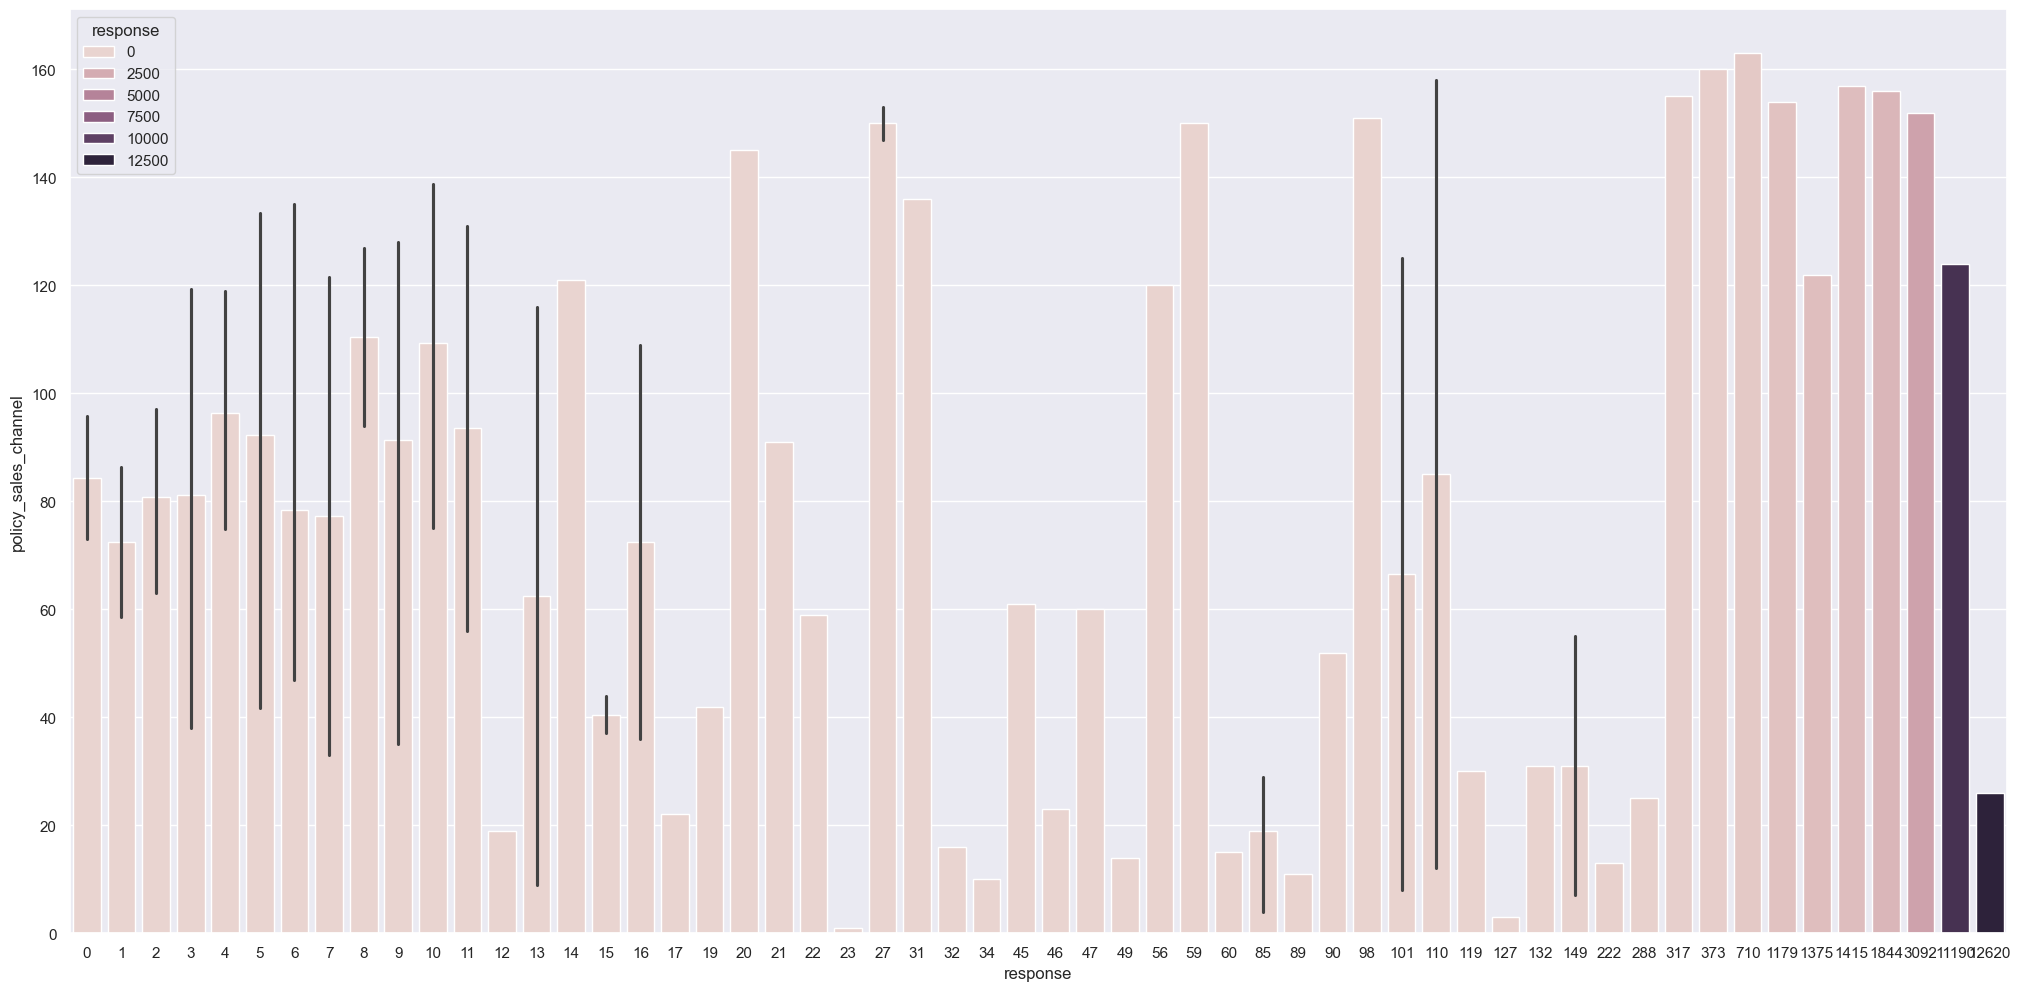

In [25]:
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux, hue='response');

### 4.1.9. Vintage

<Axes: xlabel='vintage', ylabel='Count'>

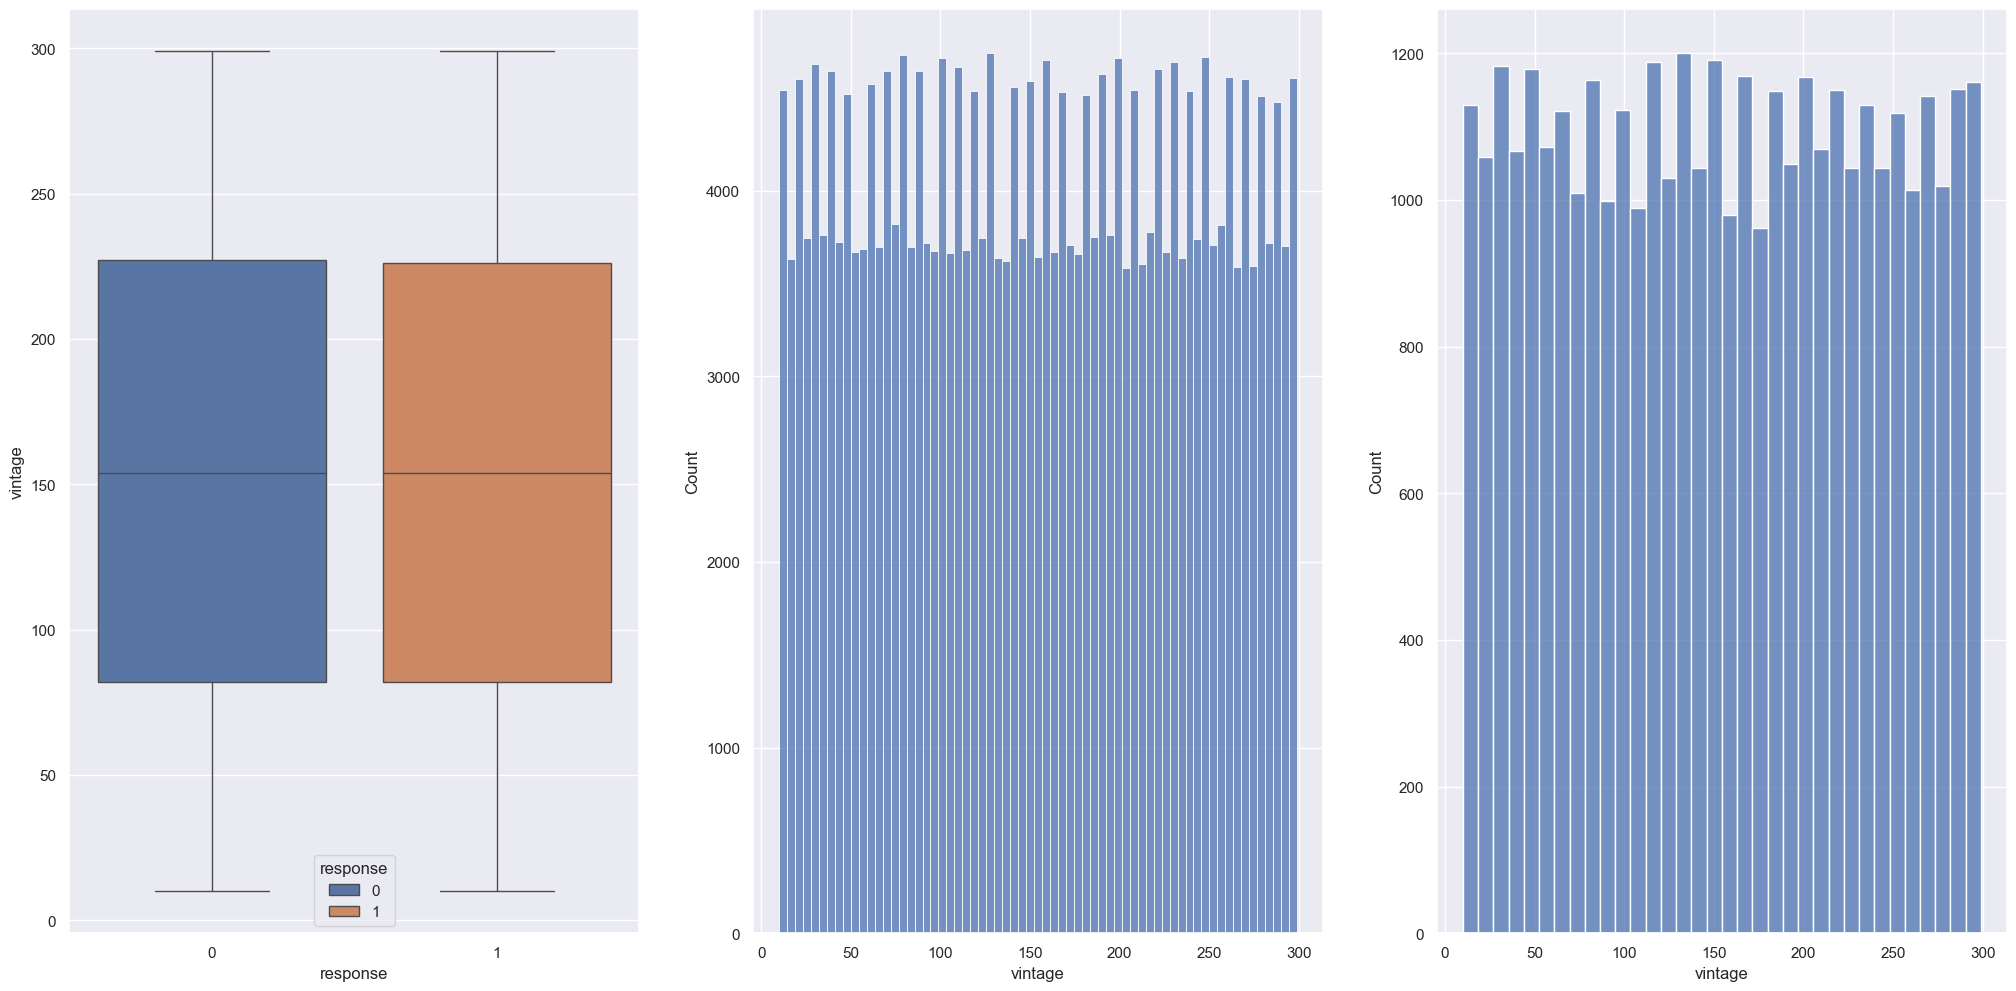

In [26]:
plt.subplot(1, 3, 1)
sns.boxplot(x='response', y='vintage', data=df4, hue='response')

plt.subplot(1, 3, 2)
aux = df4[df4['response'] == 0]['vintage']
sns.histplot(aux)

plt.subplot(1, 3, 3)
aux = df4[df4['response'] == 1]['vintage']
sns.histplot(aux)

# 5.0. Data Preparation

In [53]:
df5 = df4.copy()

In [54]:
# Divisão dos dados em treino e validação
X = df5.drop('response', axis=1)
y = df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20, random_state=42)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1. Standardization

In [55]:
ss = pp.StandardScaler()

# Annual Premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open(r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação\src\features\annual_premium_scaler.pkl', 'wb'))

## 5.2. Rescaling

In [56]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open(r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação\src\features\age_scaler.pkl', 'wb'))

# Vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open(r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação\src\features\vintage_scaler.pkl', 'wb'))

## 5.3. Encoder

In [57]:
# Driving License - Já está codado como um Label Encoding
# Vehicle Demage - Já está codado como um Label Enconding
# Previously Insured - Já está codado como um Label Encoding

# Gender - One Hot Enconding / Target Enconding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5['gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open(r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação\src\features\target_encode_gender_scaler.pkl', 'wb'))

# Region Code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open(r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação\src\features\target_encode_region_code_scaler.pkl', 'wb'))

# Vehicle Age - One Hot Enconding / Order Enconding / Frequency Enconding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# Policy Sales Channel - Target Enconding / Frequency Enconding
fe_policy_sales_channel = df5.groupby('policy_sales_channel')['response'].mean()
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open(r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação\src\features\fe_policy_sales_channel_scaler.pkl', 'wb'))

## 5.4. Validation Preparation

In [58]:
# Gender
x_validation['gender'] = x_validation['gender'].map(target_encode_gender)

# Age
x_validation['age'] = mms_age.transform(x_validation[['age']].values)

# Region Code
x_validation['region_code'] = x_validation['region_code'].map(target_encode_region_code)

# Vehicle Age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# Annual Premium
x_validation['annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# Policy Sales Channel
x_validation['policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# Vintage
x_validation['vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# Fill NA
x_validation = x_validation.fillna(0)

## 5.5 Target Variable Resampling

### 5.5.1 SMOTE + Tomek Links

In [59]:
print('Before ressampling')
y_train.value_counts()

Before ressampling


response
0    214221
1     29755
Name: count, dtype: int64

In [62]:
x_train = df5.drop(columns=['id'])

cols_new = {0: 214221,
            1: 2*88755}

# Resample
x_train_res, y_train_res = c.SMOTETomek(sampling_strategy=cols_new, random_state=42).fit_resample(x_train, y_train)

In [63]:
print('After ressampling')
y_train_res.value_counts()

After ressampling


response
0    214221
1    177510
Name: count, dtype: int64

# 6.0. Feature Selections

## 6.2. Features Importancia

In [66]:
#  Model Definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# Data Preparation
x_train_n = x_train
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                        Feature  Importance
0                      response    0.903893
0                vehicle_damage    0.041873
0            previously_insured    0.029786
0      vehicle_age_below_1_year    0.008177
0          policy_sales_channel    0.004970
0                           age    0.003710
0  vehicle_age_between_1_2_year    0.003559
0                   region_code    0.001970
0      vehicle_age_over_2_years    0.001076
0                annual_premium    0.000356
0                       vintage    0.000351
0                        gender    0.000188
0               driving_license    0.000091


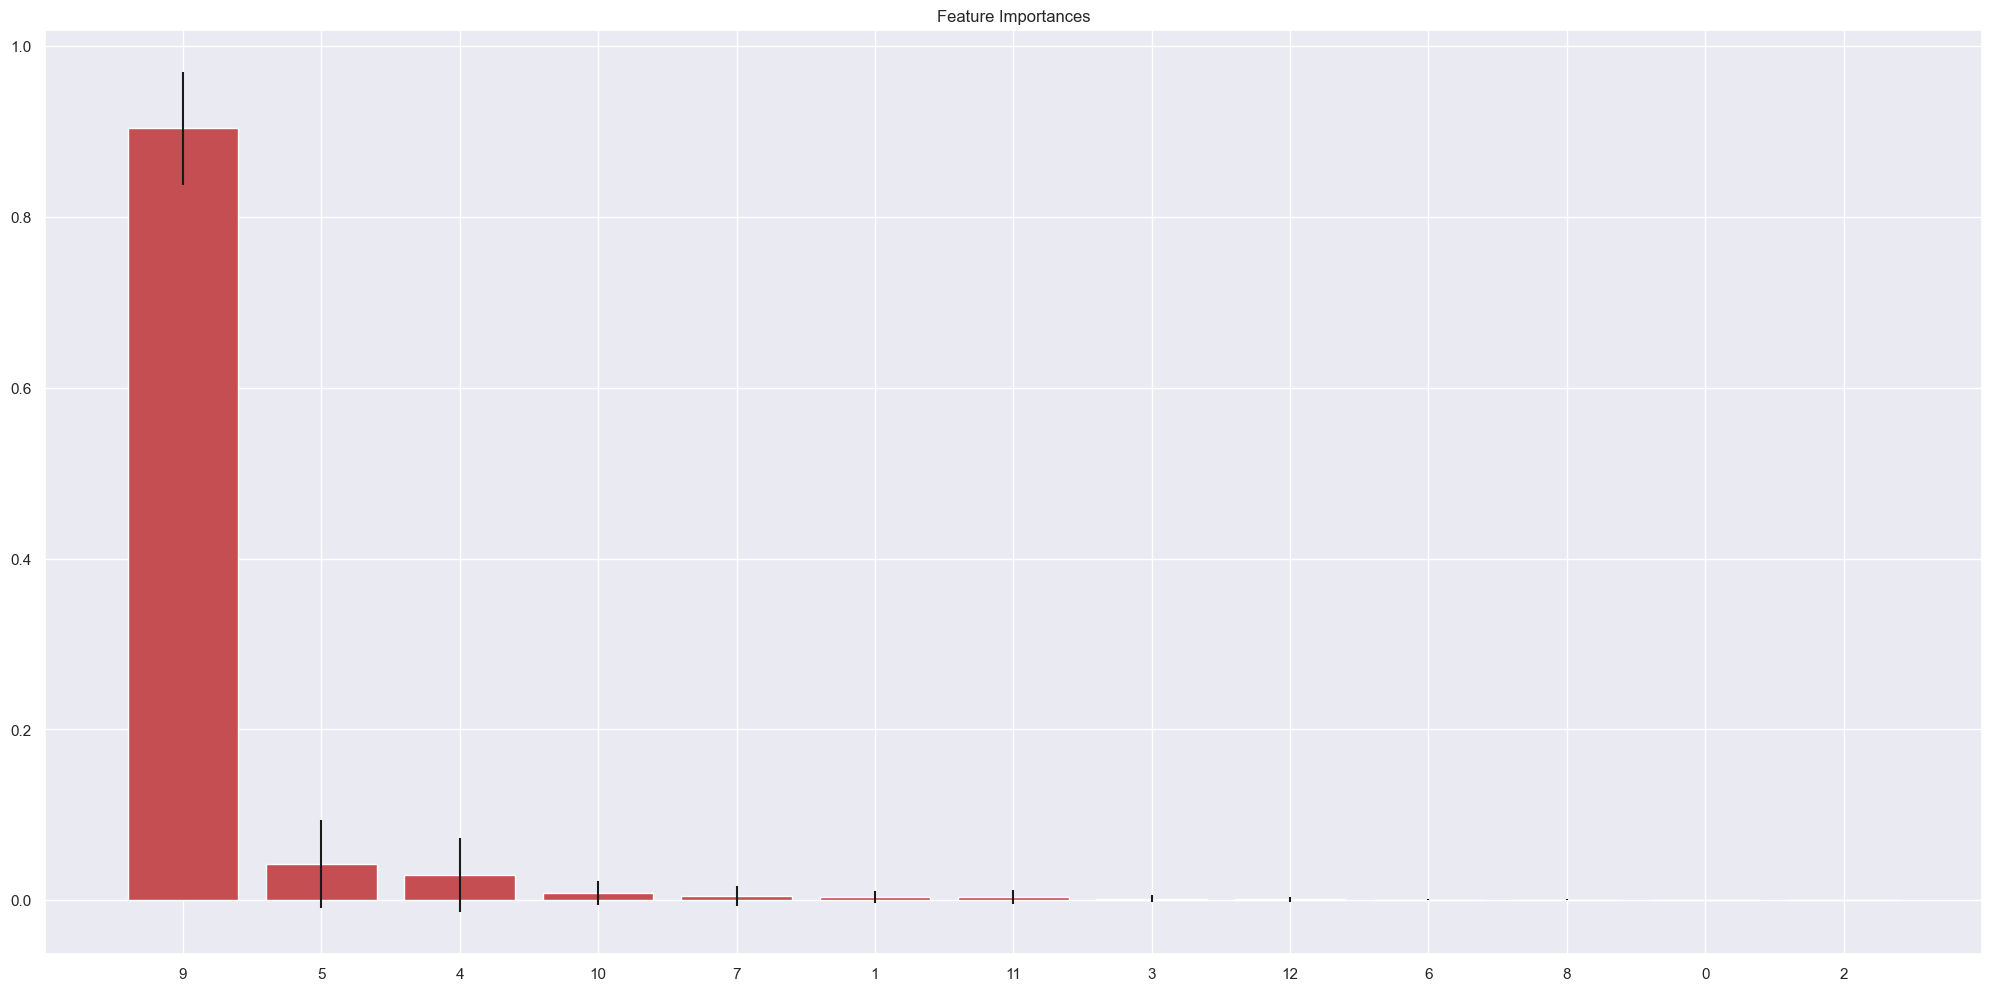

In [67]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the Feature Ranking
print('Feature Ranking:')
df = pd.DataFrame()
for i,j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'Feature': i, 'Importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('Importance', ascending=False))

# Plot the inpurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning

In [68]:
cols_select = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 
               'previously_insured']

x_train_res = x_train_res[cols_select]
x_val = x_validation[cols_select]
y_val = y_validation.copy()

## 7.1. KNN

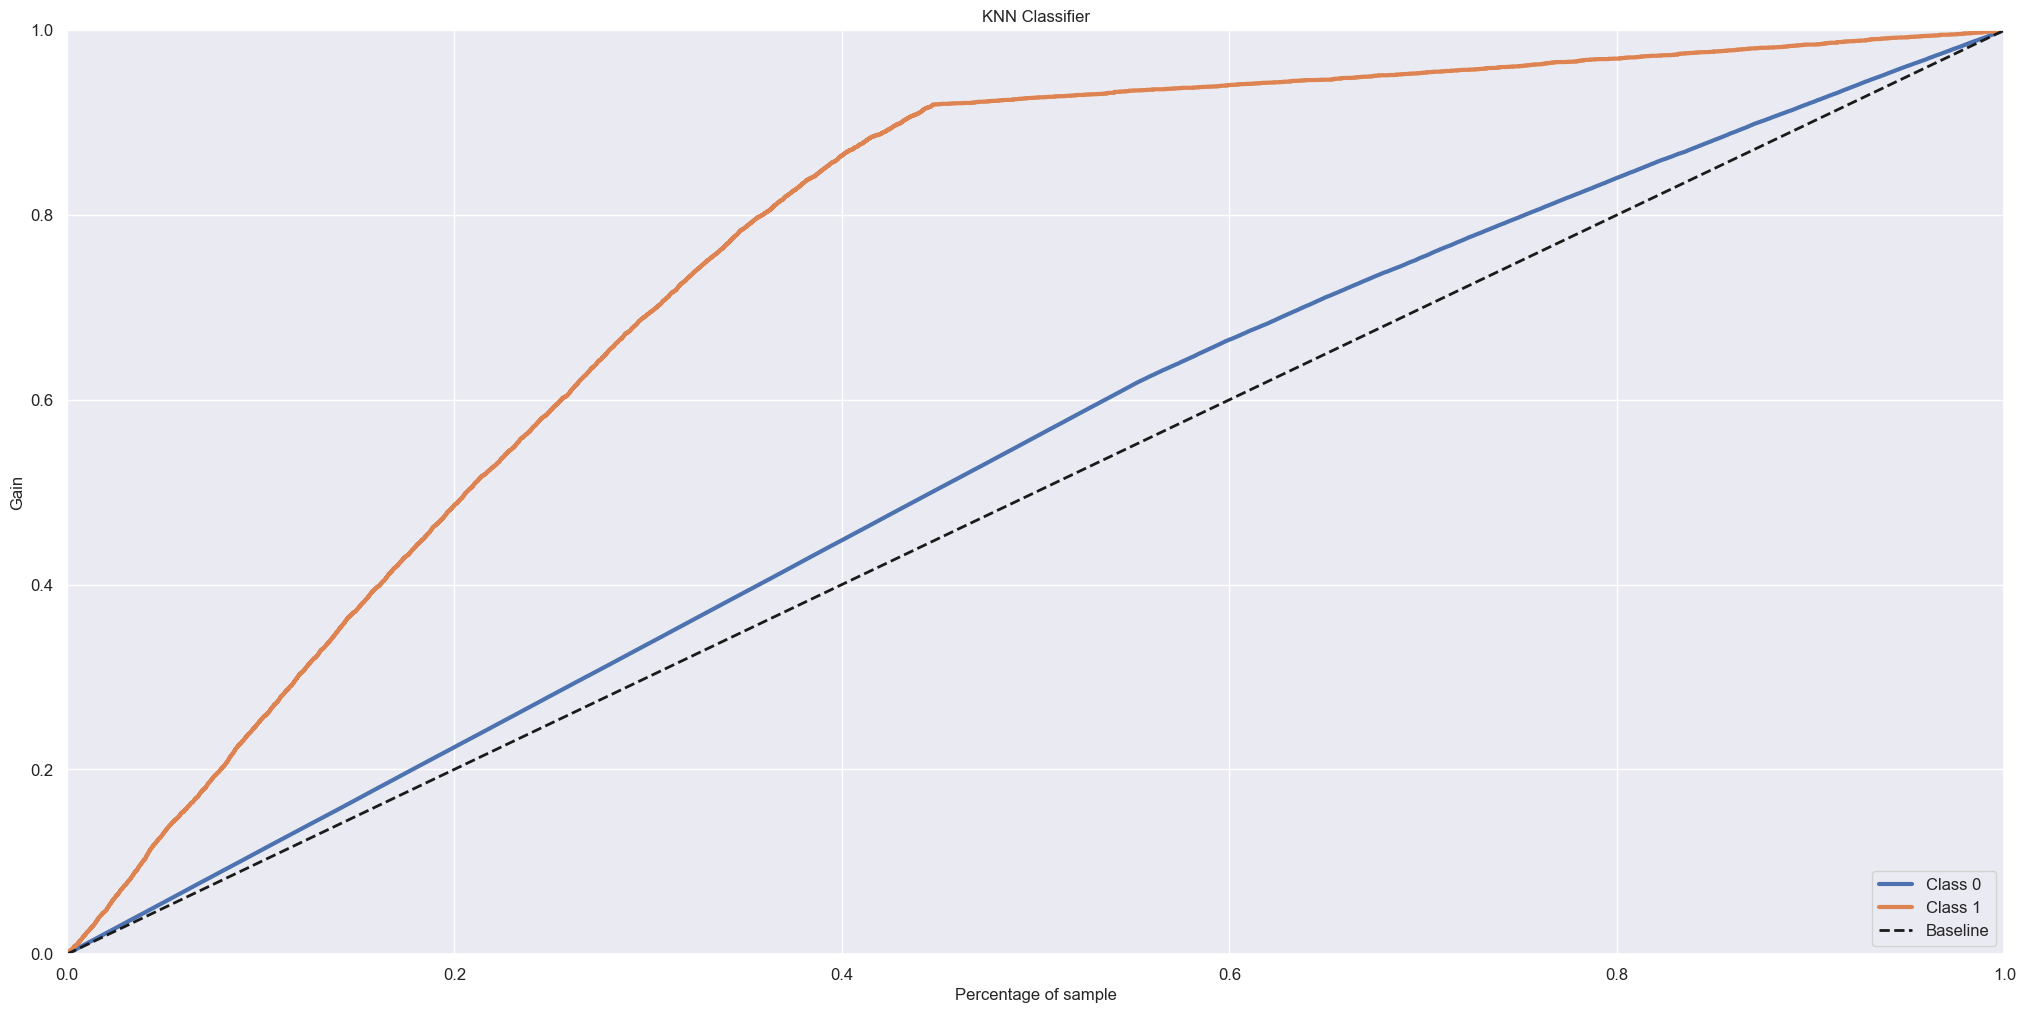

In [69]:
# Model Definition - KNN
model_knn = nh.KNeighborsClassifier(n_neighbors=7)

# Train Model
model_knn.fit(x_train_res, y_train_res)

# Prediction
yhat_knn = model_knn.predict_proba(x_val)

# Metrics
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn)
plt.title('KNN Classifier');

## 7.2. Logistic Regression

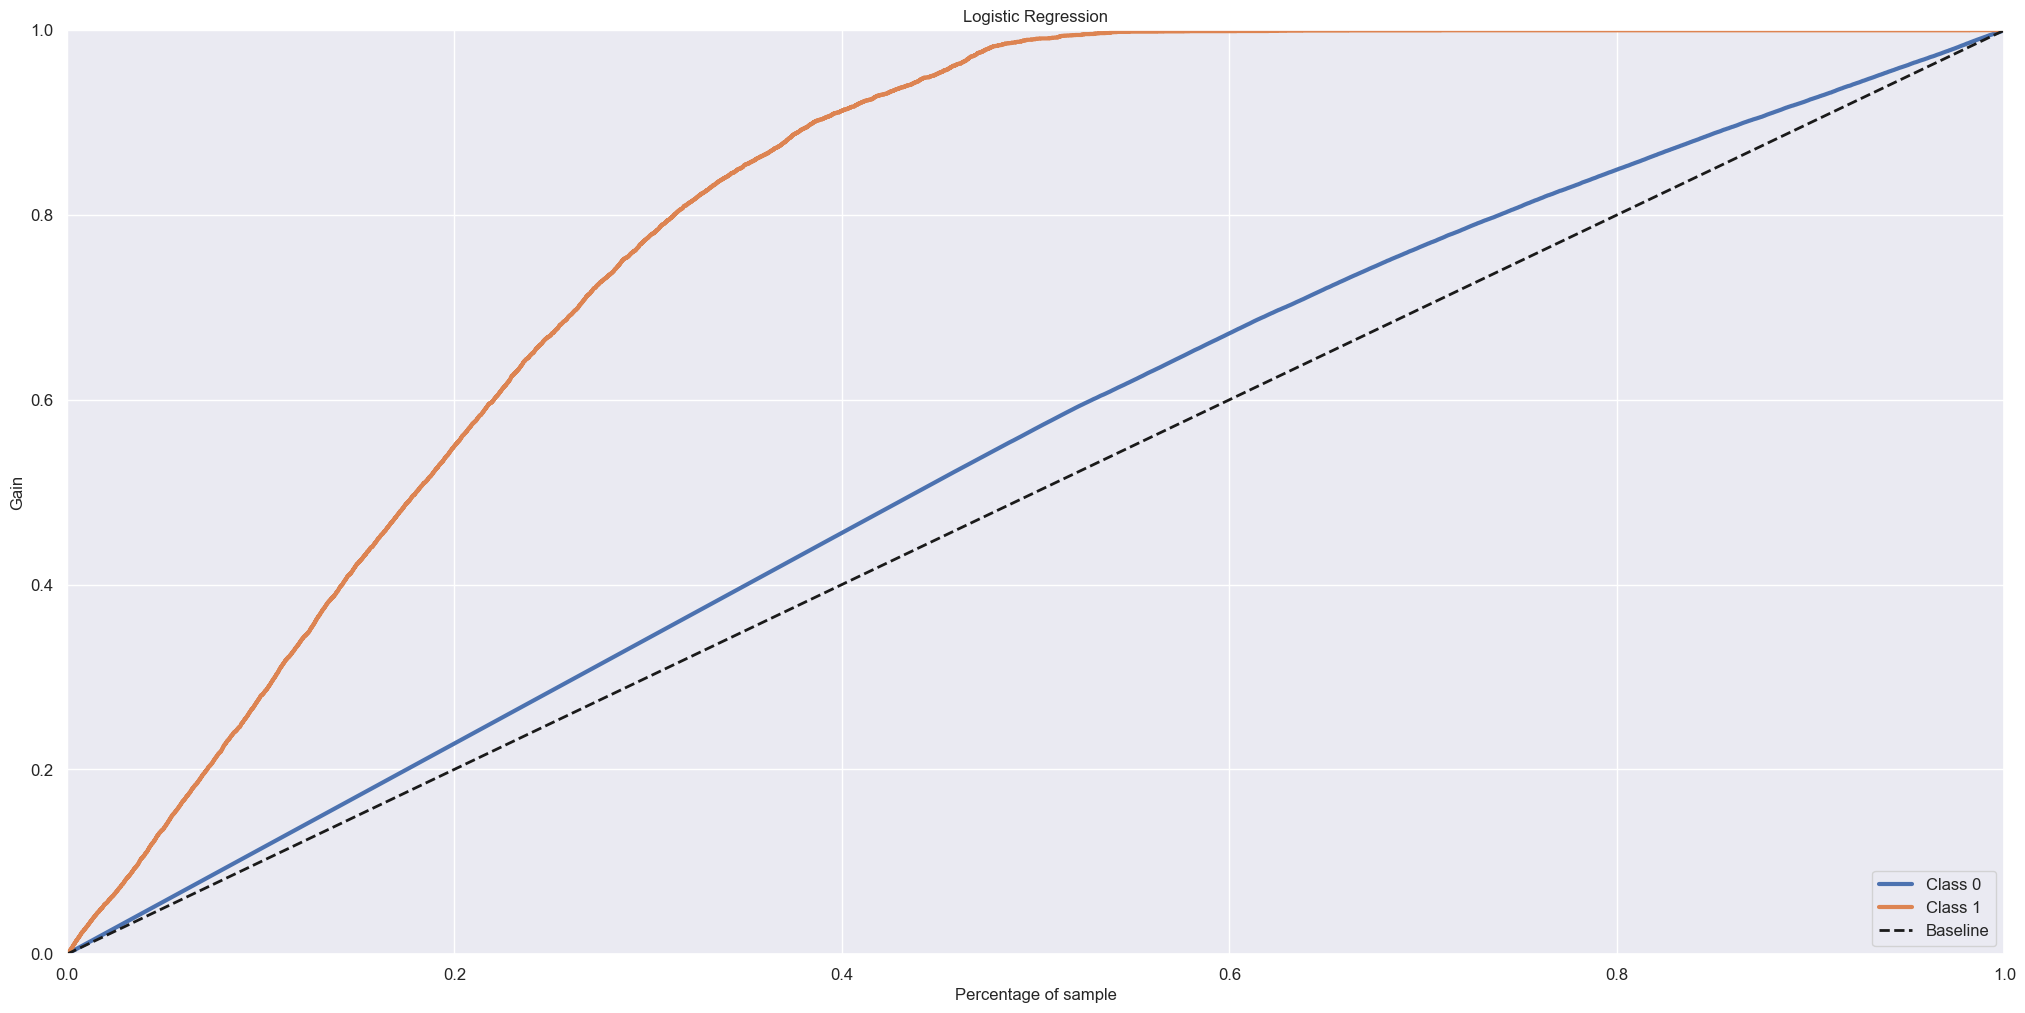

In [70]:
# Model Definition
model_lr = lm.LogisticRegression(random_state=42)

# Train Model
model_lr.fit(x_train_res, y_train_res)

# Prediction
yhat_lr = model_lr.predict_proba(x_val)

# Metrics
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr)
plt.title('Logistic Regression');

## 7.3. Naive Bayes

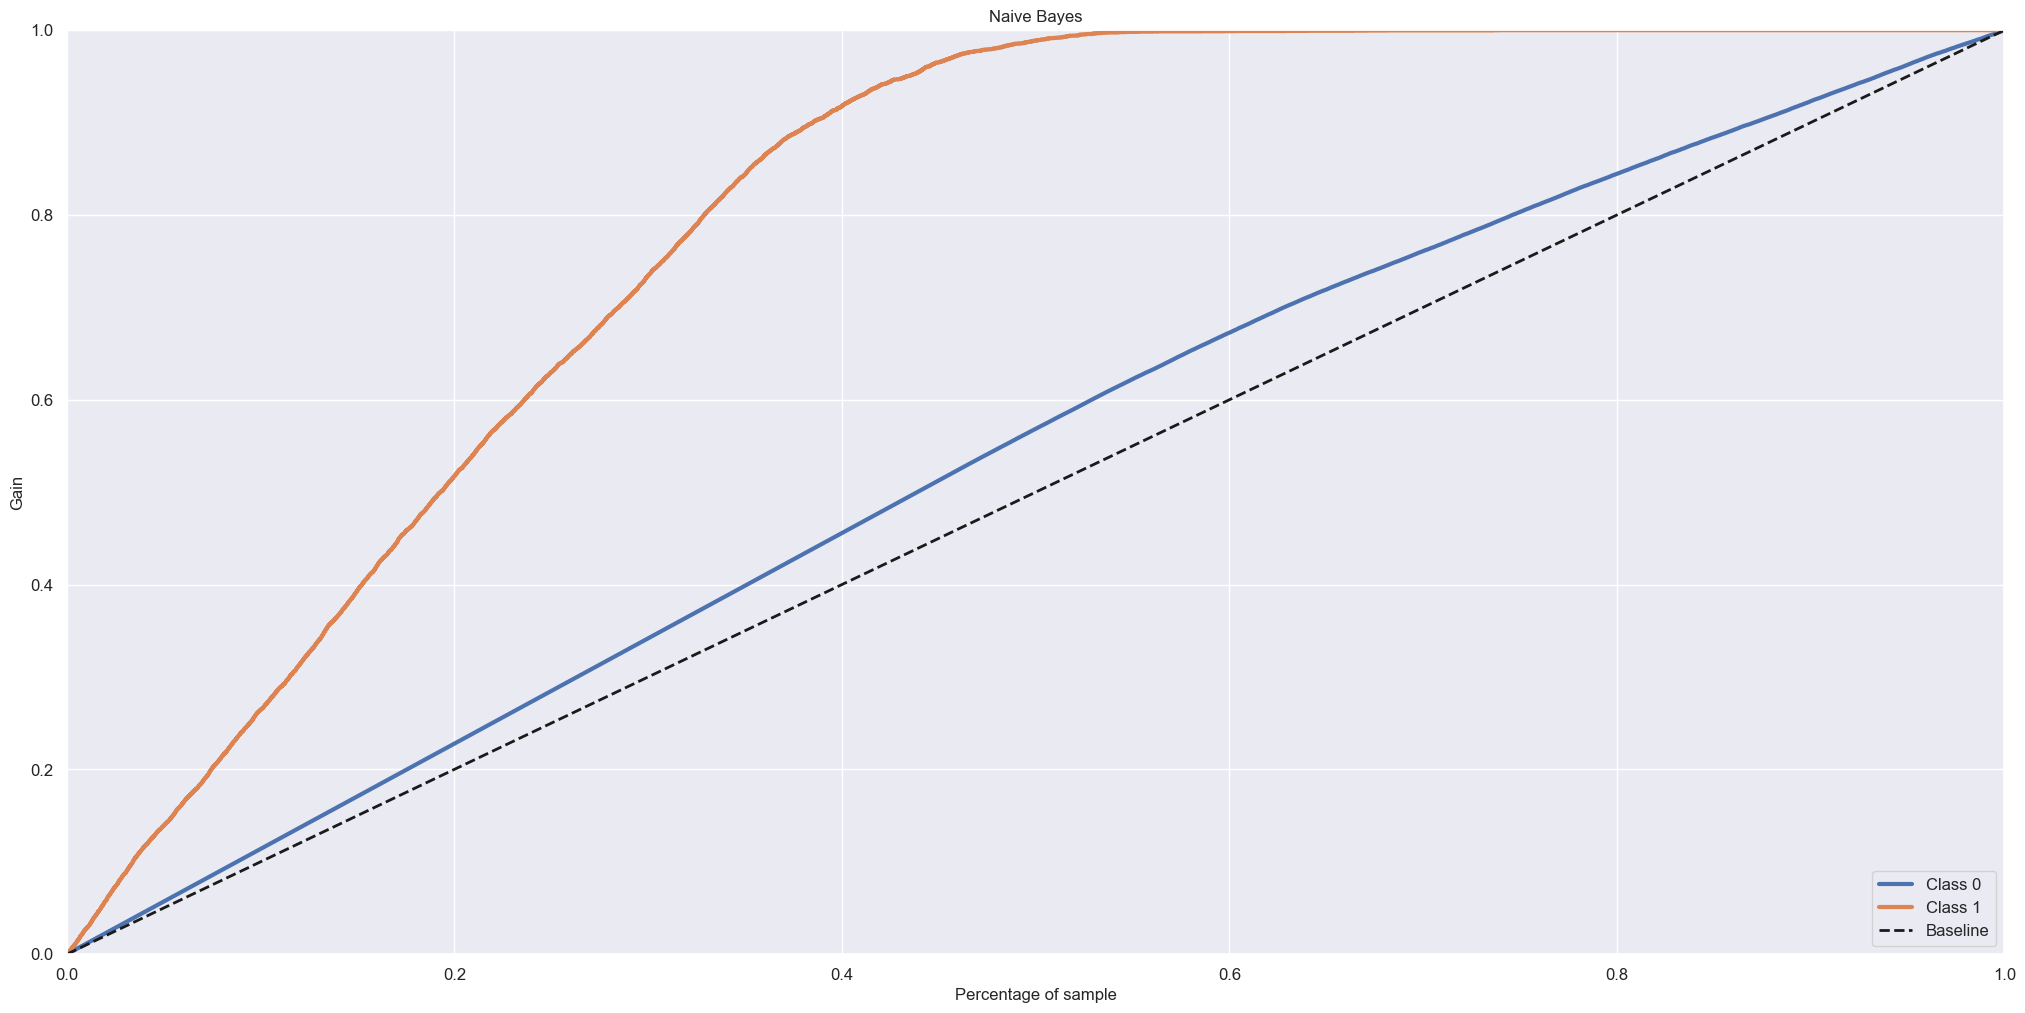

In [71]:
# Model Definition
model_nb = nb.GaussianNB()

# Train Model
model_nb.fit(x_train_res, y_train_res)

# Prediction
yhat_nb = model_nb.predict_proba(x_val)

# Metrics
skplt.metrics.plot_cumulative_gain(y_val, yhat_nb)
plt.title('Naive Bayes');

## 7.4. Random Forest

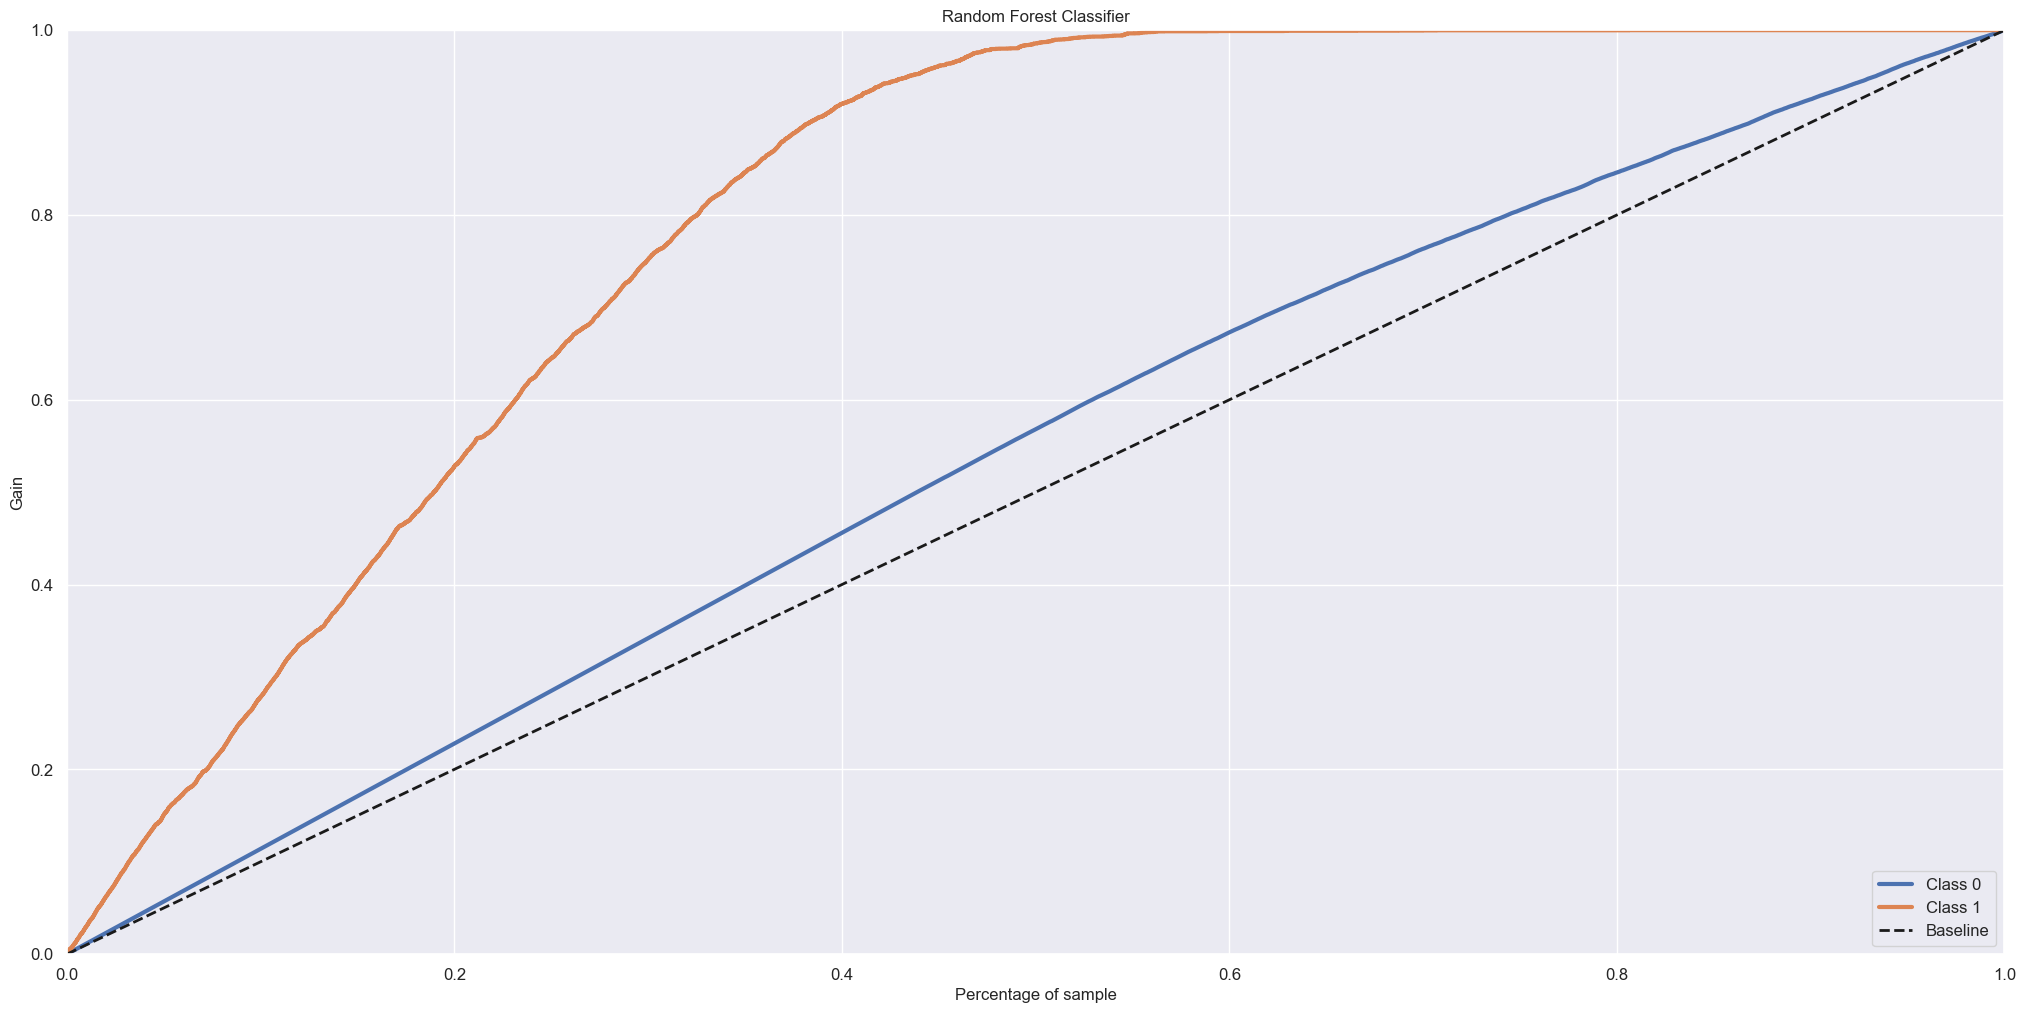

In [72]:
# Model Definition
model_rf = en.RandomForestClassifier(max_depth=2, random_state=42)

# Train Model
model_rf.fit(x_train_res, y_train_res)

# Prediction
yhat_rf = model_rf.predict_proba(x_val)

# Metrics
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf)
plt.title('Random Forest Classifier');

## 7.5. Gradient Boosting Machines - GBM

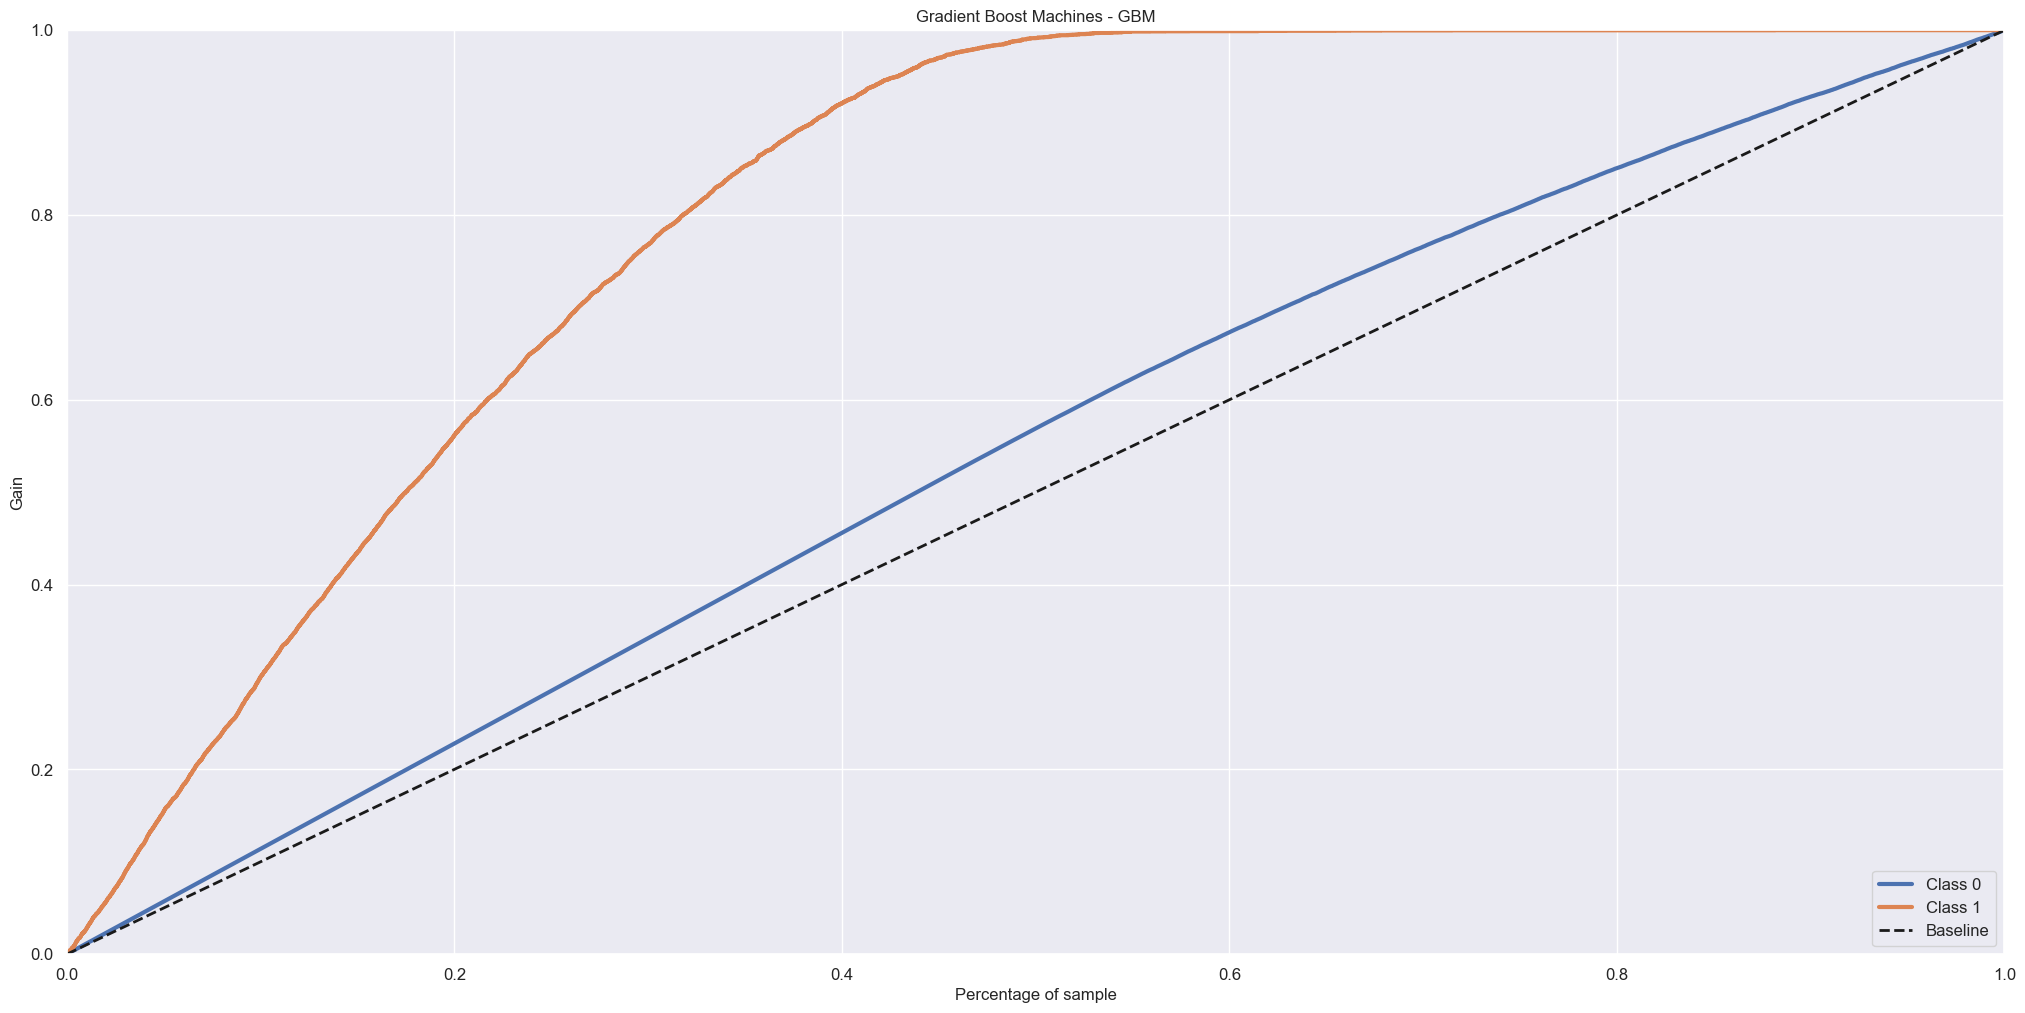

In [73]:
# Model Definition
model_gbm = en.GradientBoostingClassifier(max_depth=2, random_state=42)

# Train Model
model_gbm.fit(x_train_res, y_train_res)

# Prediction
yhat_gbm = model_gbm.predict_proba(x_val)

# Metrics
skplt.metrics.plot_cumulative_gain(y_val, yhat_gbm)
plt.title('Gradient Boost Machines - GBM');

## 7.6. XGBoost Classifier

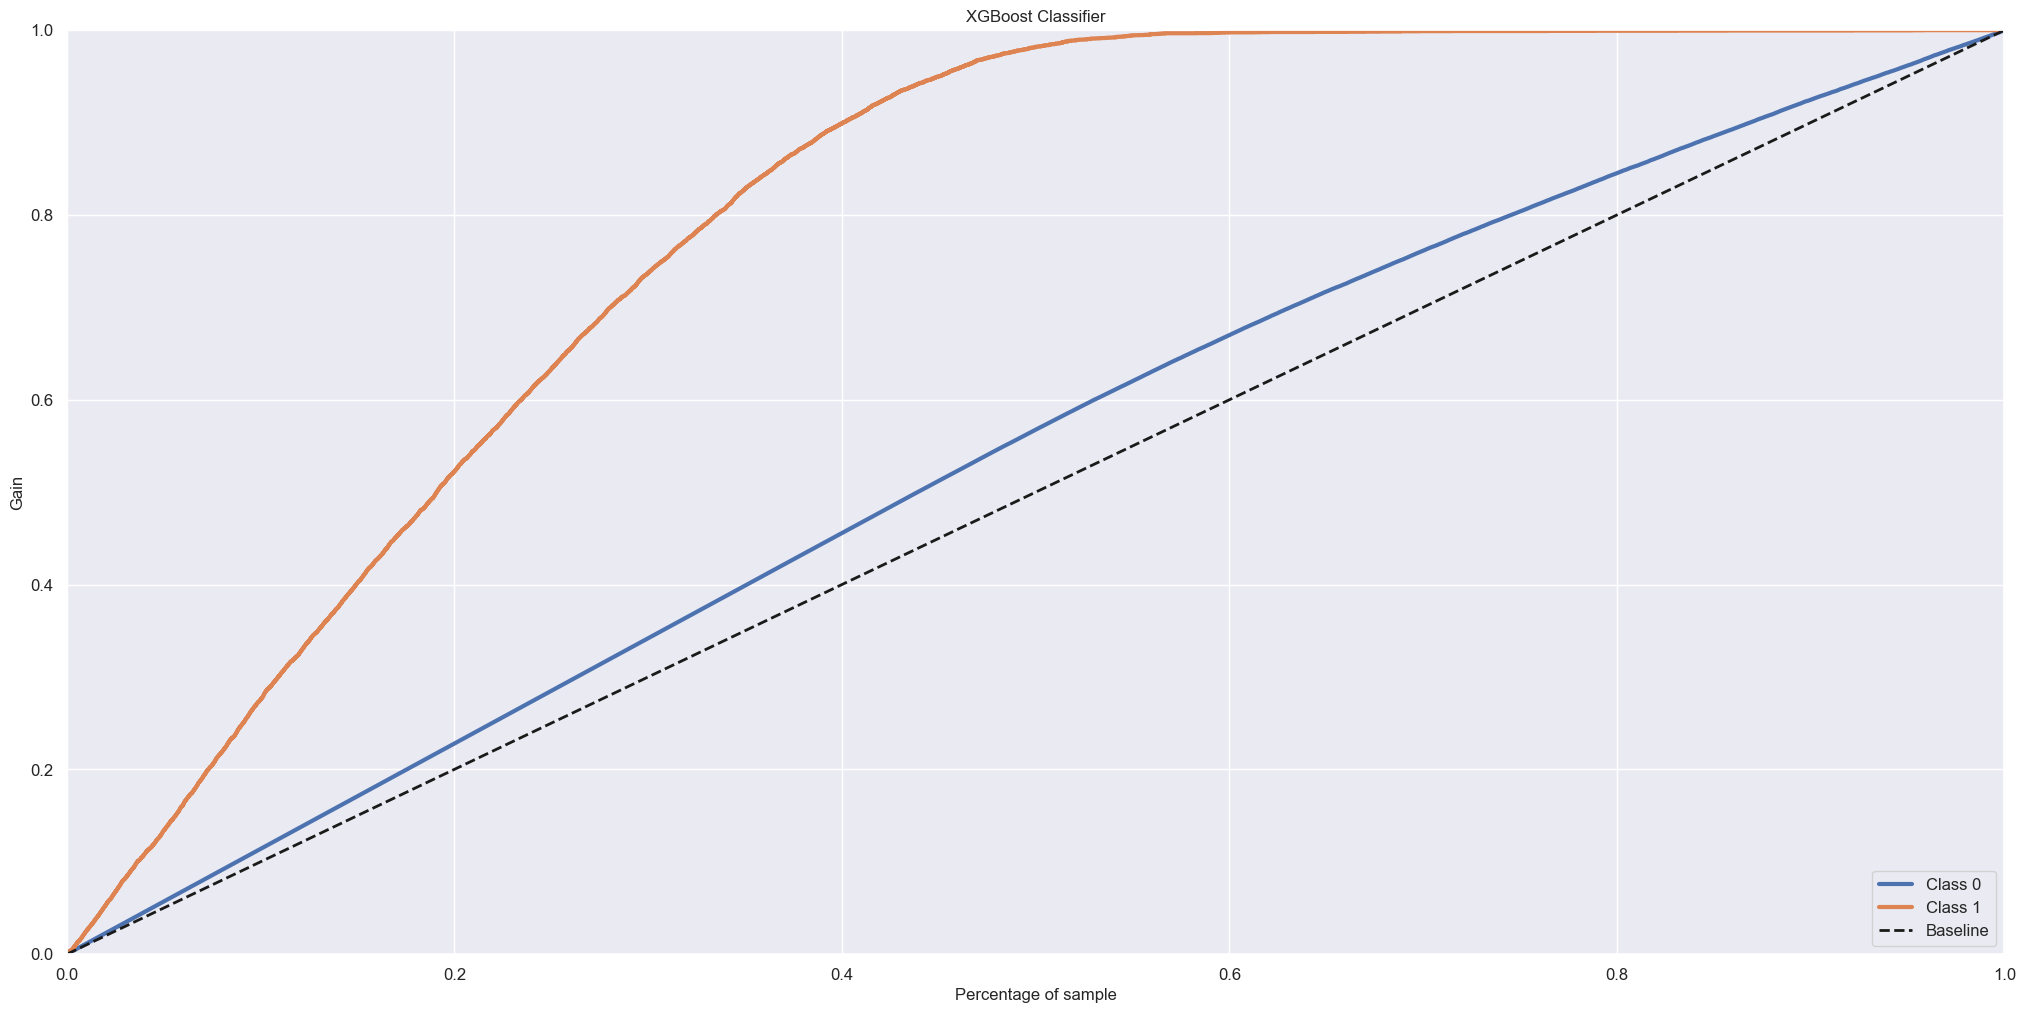

In [74]:
# Model Definition
model_xgb = xgb.XGBClassifier(n_estimators=1500)

# Train Model
model_xgb.fit(x_train_res, y_train_res)

# Prediction
yhat_xgb = model_xgb.predict_proba(x_val)

# Metrics
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb)
plt.title('XGBoost Classifier');

## 7.7. Light GBM Classifier

[LightGBM] [Info] Number of positive: 177510, number of negative: 214221
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 391731, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453143 -> initscore=-0.187981
[LightGBM] [Info] Start training from score -0.187981


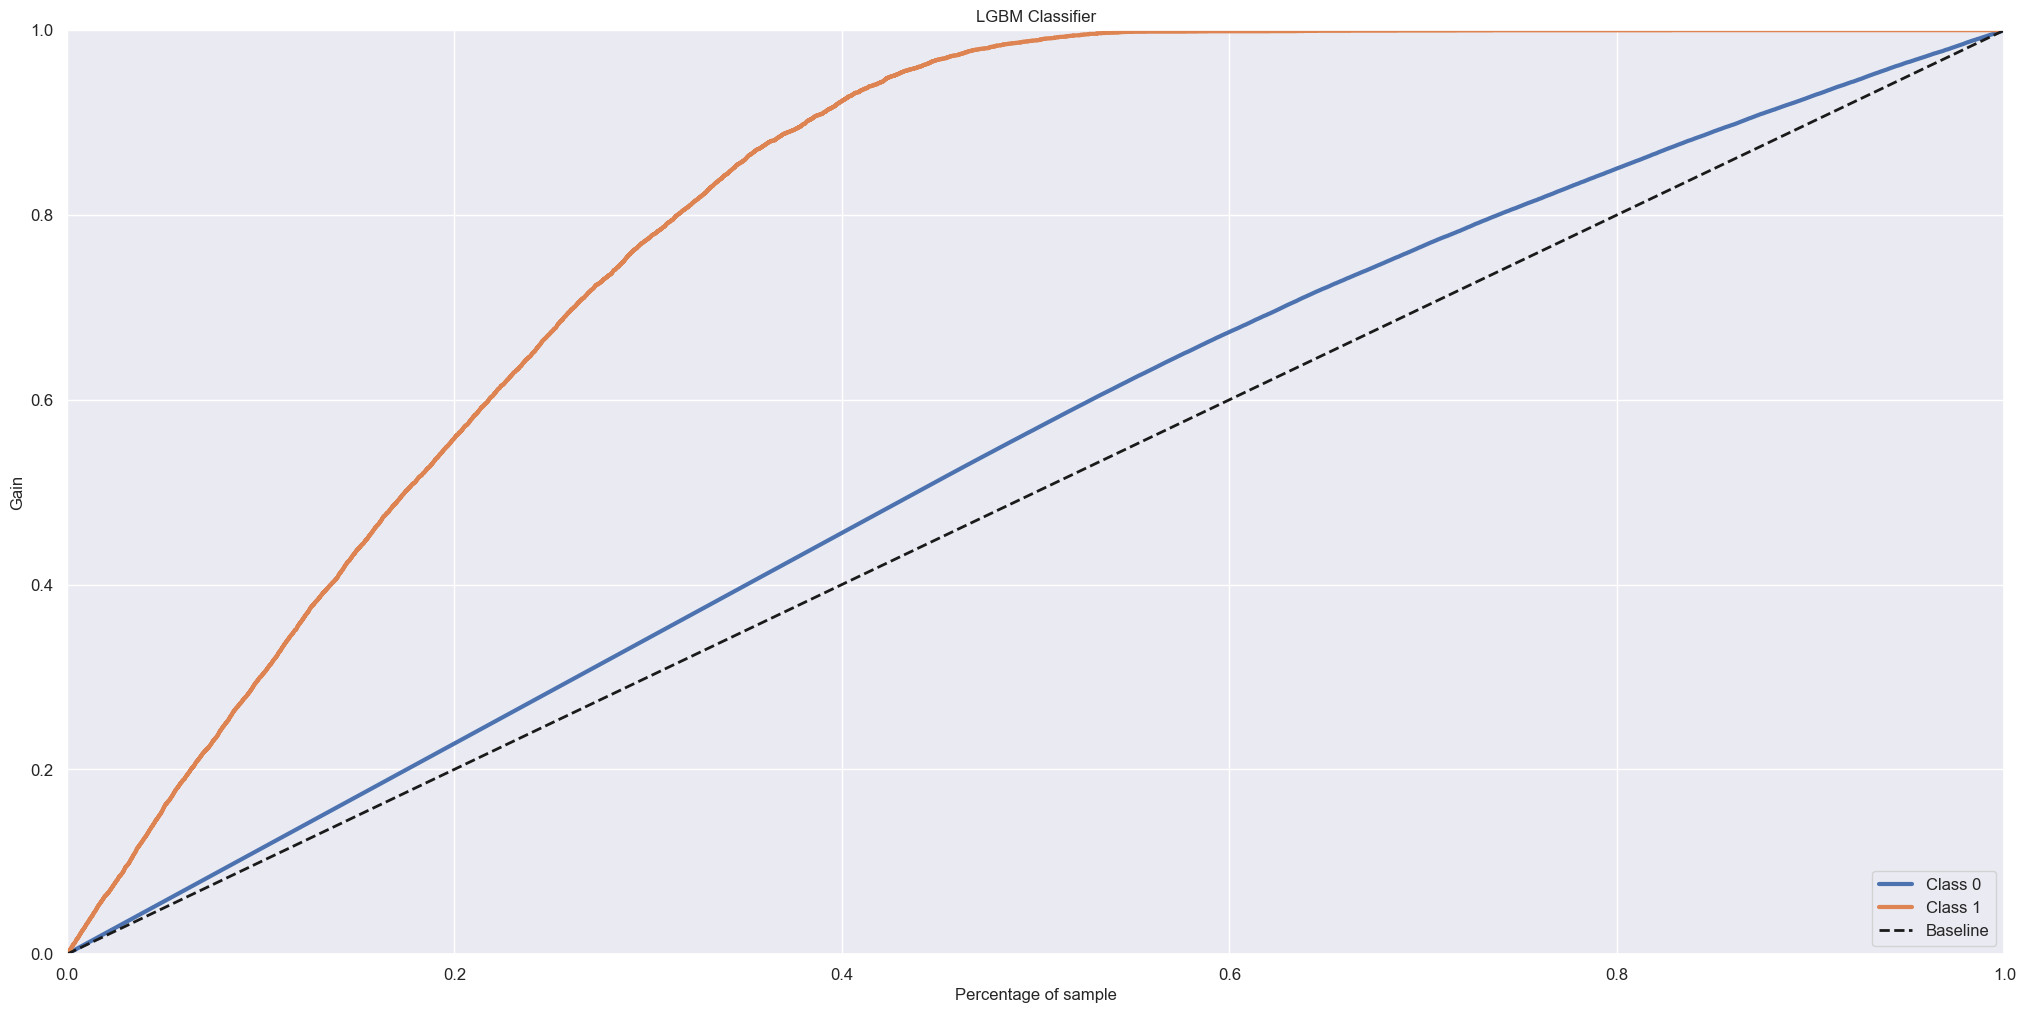

In [75]:
# Model Definition
model_lgbm = lgbm.LGBMClassifier(n_estimators=1500)

# Train Model
model_lgbm.fit(x_train_res, y_train_res)

# Prediction
yhat_lgbm = model_lgbm.predict_proba(x_val)

# Metrics
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm)
plt.title('LGBM Classifier');

## 7.9. Real Model Performace: Cross Validarion with Learning to Rank Metrics

In [77]:
knn_val  = cross_validation(model_knn,  x_train_res, y_train_res, 5, df5, verbose=False)
lr_val   = cross_validation(model_lr,   x_train_res, y_train_res, 5, df5, verbose=False)
nb_val   = cross_validation(model_nb,   x_train_res, y_train_res, 5, df5, verbose=False)
rf_val   = cross_validation(model_rf,   x_train_res, y_train_res, 5, df5, verbose=False)
gbm_val  = cross_validation(model_gbm,  x_train_res, y_train_res, 5, df5, verbose=False)
xgb_val  = cross_validation(model_xgb,  x_train_res, y_train_res, 5, df5, verbose=False)
lgbm_val = cross_validation(model_lgbm, x_train_res, y_train_res, 5, df5, verbose=False)

[LightGBM] [Info] Number of positive: 142008, number of negative: 171376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 313384, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453144 -> initscore=-0.187977
[LightGBM] [Info] Start training from score -0.187977
[LightGBM] [Info] Number of positive: 142008, number of negative: 171377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 313385, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453142 -> initscore=-0.18798

In [79]:
results = pd.concat([knn_val, lr_val, nb_val, rf_val, gbm_val, xgb_val, lgbm_val])
results.sort_values(by='Recall Mean', ascending=False)

,Model Name,Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,GaussianNB,0.7676,0.6660,0.0019,0.9773,0.0003,0.7344,0.0020,0.4137,0.0011
0,KNeighborsClassifier,0.8427,0.7609,0.0022,0.9521,0.0009,0.8843,0.0025,0.4982,0.0014
0,GradientBoostingClassifier,0.8236,0.7470,0.0016,0.9234,0.0014,0.9230,0.0033,0.5200,0.0019
0,RandomForestClassifier,0.7828,0.7014,0.0022,0.9066,0.0016,0.7993,0.0040,0.4503,0.0022
0,LogisticRegression,0.7835,0.7071,0.0017,0.8915,0.0018,0.7520,0.0039,0.4237,0.0022
0,LGBMClassifier,0.9095,0.9572,0.0013,0.8377,0.0024,1.0000,0.0000,0.5634,0.0000
0,XGBClassifier,0.8755,0.8827,0.0034,0.8365,0.0023,0.9997,0.0002,0.5632,0.0001


# 8.0. Model Performace

In [140]:
# Copy Data
df8 = x_val.copy()
df8['response'] = y_val.copy()

# Propensity Score
df8['score'] = yhat_lgbm[:, 1].tolist()

# Sorted Clientes by Propensity Score
df8 = df8.sort_values('score', ascending=False)

# Compute Precision at k
precision_at_50 = precision_at_k(df8, k=2000)
print(f'Precision at K: {precision_at_50}')

# Compute Recall at k
precision_at_50 = recall_at_k(df8, k=2000)
print(f'Recall at K: {precision_at_50}')

Precision at K: 0.3613193403298351
Recall at K: 0.0963743001866169


# 9.0. Final Model

In [151]:
model_lgbm = lgbm.LGBMClassifier(n_estimators=1500, verbose=-1)

# Training
lgbm_model = cross_validation(model_lgbm,  x_train_res, y_train_res, 10, df5, verbose=True)

# Prediction
yhat_lgbm = model_lgbm.predict_proba(x_val)

Fold Number 1/10
Fold Number 2/10
Fold Number 3/10
Fold Number 4/10
Fold Number 5/10
Fold Number 6/10
Fold Number 7/10
Fold Number 8/10
Fold Number 9/10
Fold Number 10/10


# 10.0. Business Performance

In [152]:
data = x_val.copy()
data['response'] = y_val.copy()
data['score'] = yhat_lgbm[:, 1].tolist()
data = data.sort_values('score', ascending=False)

## 10.1. --- 2.000 Calls ---

In [164]:
percent_of_dataset = 2000 / len(data)
recall_at_2000 = recall_at_k(data, k=2000)
precision_at_2000 = precision_at_k(data,k=2000)

print(f'Percent of Data: {percent_of_dataset * 100:.2f}')
print(f'Recall at 2000: {recall_at_2000 * 100:.2f}')
print(f'Precision at 2000: {precision_at_2000 * 100:.2f}')

Percent of Data: 3.28
Recall at 2000: 10.14
Precision at 2000: 38.03


### Ao utilizar 3,28% dos dados de validação, 2 mil ligações da equipe de vendas, o modelo seria capaz de identificar 10,14% de pessoas interessadas em adquirir o seguro.

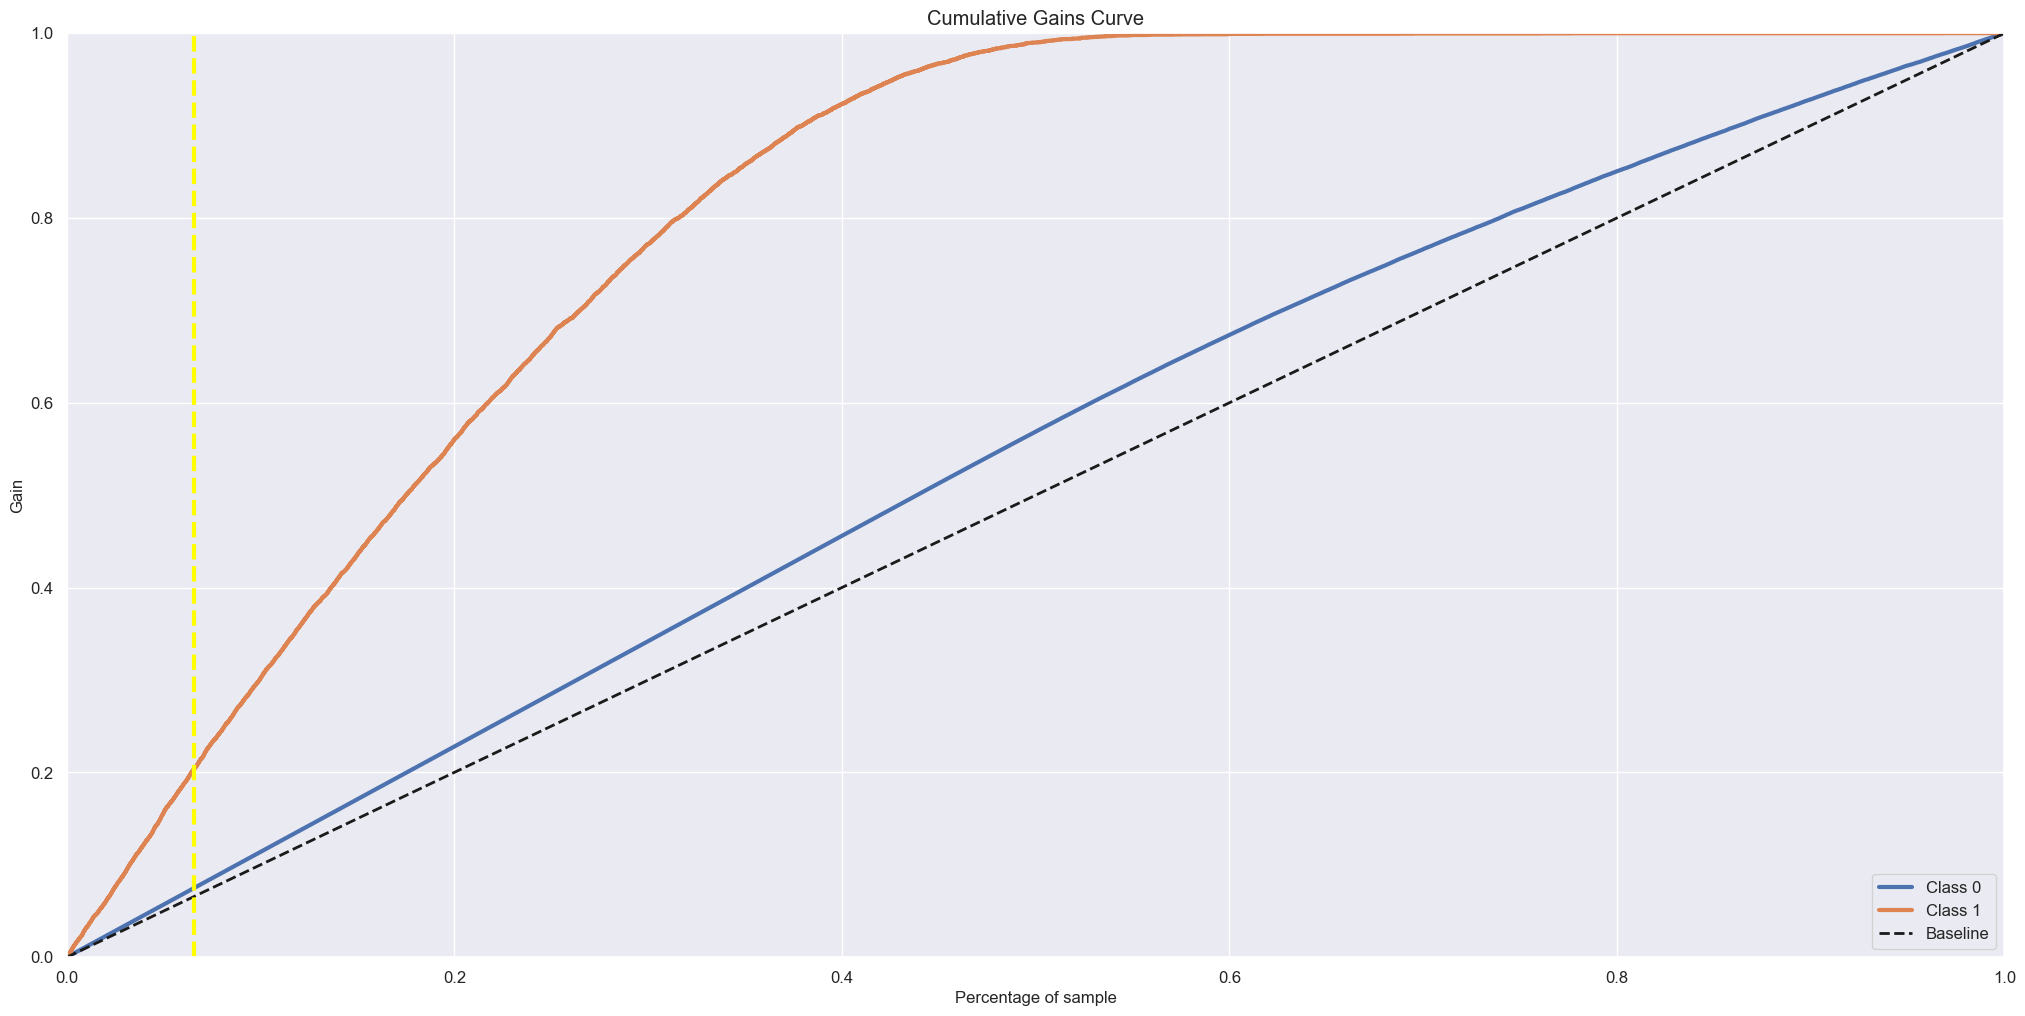

In [168]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

## 10.2. --- 4.000 Calls ---

In [172]:
percent_of_dataset = 4000 / len(data)
recall_at_4000 = recall_at_k(data, k=4000)
precision_at_4000 = precision_at_k(data,k=4000)

print(f'Percent of Data: {percent_of_dataset * 100:.2f}')
print(f'Recall at 4000: {recall_at_4000 * 100:.2f}')
print(f'Precision at 4000: {precision_at_4000 * 100:.2f}')

Percent of Data: 6.56
Recall at 4000: 20.38
Precision at 4000: 38.22


### Ao utilizar 6,56% dos dados de validação, 2 mil ligações da equipe de vendas, o modelo seria capaz de identificar 20,38% de pessoas interessadas em adquirir o seguro.

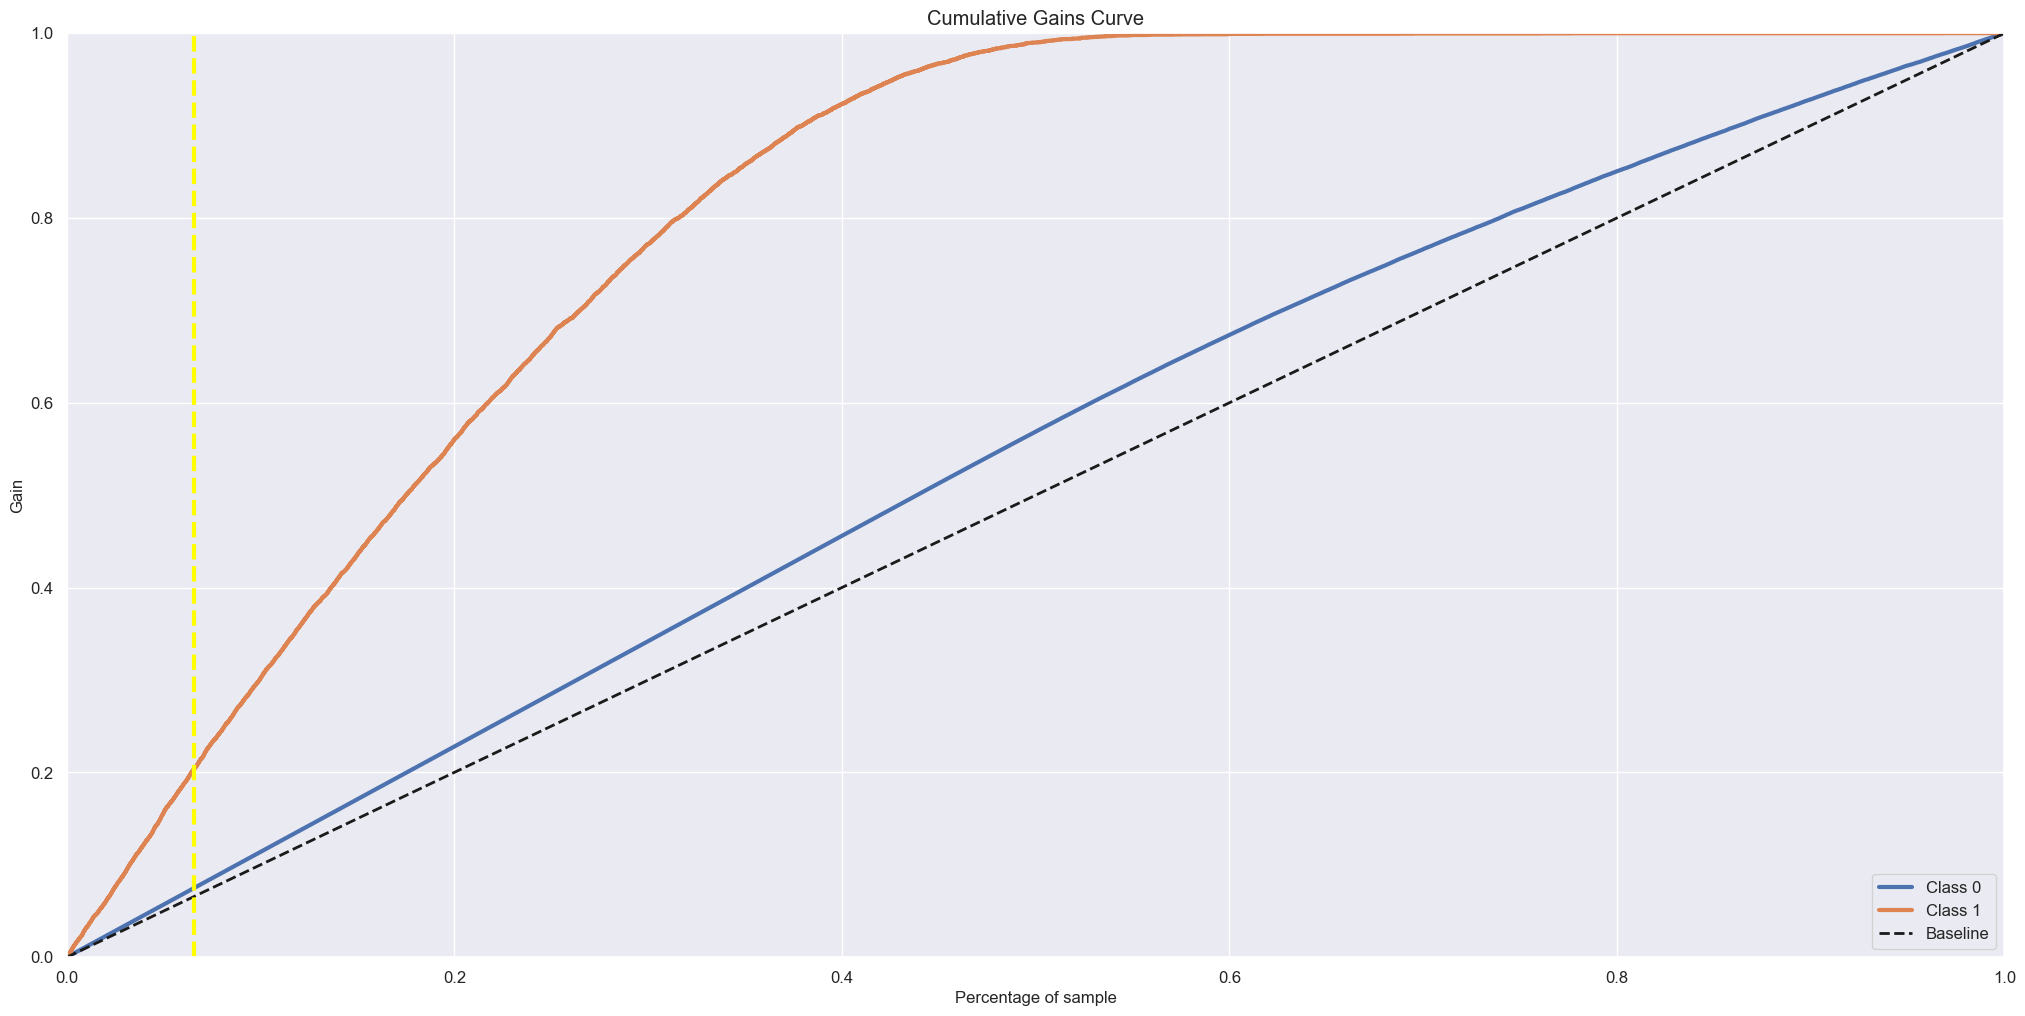

In [173]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

## 10.3. Business Perfomence on 127.000 New Customers

### 10.3.1 Revenue by making 2.000 Calls

In [179]:
random_choice = (3/100) * 127000
model         = (10/100) * 127000

x = random_choice * (2000*12)
y = model * (2000*12)
dif = y-x

print(f'{x} Annual revenue with random choice')
print(f'{y} Annual revenue with model')
print(f'difference in $: {dif}')

91440000.0 Annual revenue with random choice
304800000.0 Annual revenue with model
difference in $: 213360000.0


### 10.3.2 Revenue by making 4.000 Calls

In [180]:
random_choice = (6/100) * 127000
model         = (20/100) * 127000

x = random_choice * (2000*12)
y = model * (2000*12)
dif=y-x

print(f'{x} Annual revenue with random choice')
print(f'{y} Annual revenue with model')
print(f'difference in $: {dif}')

182880000.0 Annual revenue with random choice
609600000.0 Annual revenue with model
difference in $: 426720000.0


### 10.3.3 How many calls to reach 80% of peaple interested

Percent of Data: 31.56%
Recall at 19250: 80.01%
Precision at 19250: 31.18%


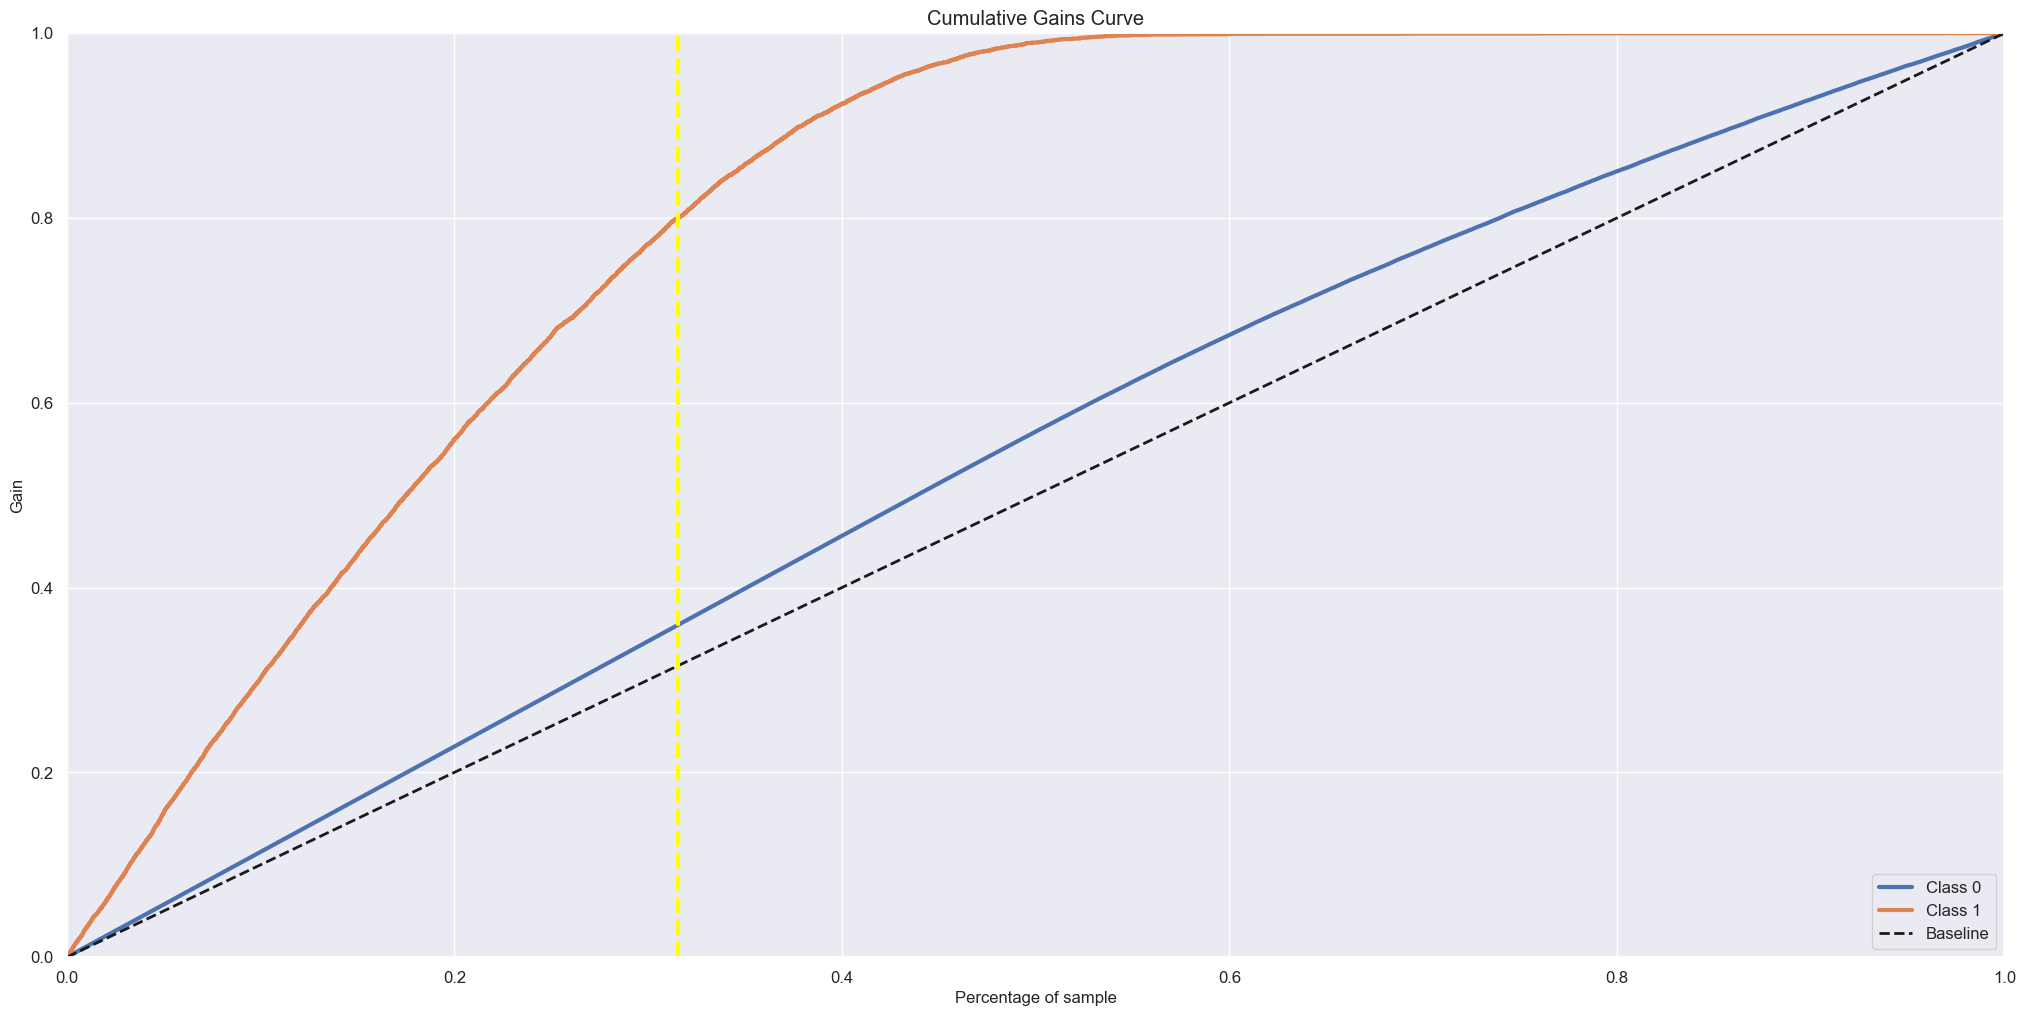

In [196]:
num = input('Entre com o valor de ligações que deseja realizar:')
percent_of_dataset = int(num) / len(data)
recall_at_num = recall_at_k(data, k=int(num))
precision_at_num=precision_at_k(data, k=int(num))

print(f'Percent of Data: {percent_of_dataset * 100:.2f}%')
print(f'Recall at {num}: {recall_at_num * 100:.2f}%')
print(f'Precision at {num}: {precision_at_num * 100:.2f}%')

skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

# 11.0. Deploy to Production

In [56]:
# Save trained model
pickle.dump(model_lr, open(r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação\src\models\model_linear_regression.pkl', 'wb'))

## 11.1. Health Insurace Class

In [57]:
class HealthInsurance:
    def __init__(self):
        self.home_path                          = r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação'
        self.annual_premium_scaler              = pickle.load(open(self.home_path + r'\src\features\annual_premium_scaler.pkl', 'rb'))
        self.age_scaler                         = pickle.load(open(self.home_path + r'\src\features\age_scaler.pkl', 'rb'))
        self.vintage_scaler                     = pickle.load(open(self.home_path + r'\src\features\vintage_scaler.pkl', 'rb'))
        self.target_encode_gender_scaler        = pickle.load(open(self.home_path + r'\src\features\target_encode_gender_scaler.pkl', 'rb'))
        self.target_encode_region_code_scaler   = pickle.load(open(self.home_path + r'\src\features\target_encode_region_code_scaler.pkl', 'rb'))
        self.fe_prolicy_sales_channel_scaler    = pickle.load(open(self.home_path + r'\src\features\fe_prolicy_sales_channel_scaler.pkl', 'rb'))

    def data_cleaning(self, data):
        ## 1.1. Rename Columns
        data.columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
                     'Policy_Sales_Channel', 'Vintage', 'Response']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        # Rename Columns
        data.columns = cols_new

        return data
    
    def feature_engineering(self, data):
        # Vehicle Age
        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

        # Vejicle Demage
        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        return data
    

    def data_preparation(self, data):
        ## 5.1. Standardization
        # Annual Premium
        data['annual_premium'] = self.annual_premium_scaler.transform(data[['annual_premium']].values)
        
        ## 5.2. Rescaling
        # Age
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # Vintage
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)

        ## 5.3. Encoder
        # Gender - One Hot Enconding / Target Enconding
        target_encode_gender = data.groupby('gender')['response'].mean()
        data['gender'] = data['gender'].map(self.target_encode_gender_scaler)

        # Region Code - Frequency Encoding / Target Encoding / Weighted Target Encoding
        data['region_code'] = data['region_code'].map(self.target_encode_region_code_scaler)

        # Vehicle Age - One Hot Enconding / Order Enconding / Frequency Enconding
        data = pd.get_dummies(data, prefix='vehicle_age', columns=['vehicle_age'])

        # Policy Sales Channel - Target Enconding / Frequency Enconding
        data['policy_sales_channel'] = data['policy_sales_channel'].map(self.fe_prolicy_sales_channel_scaler)

        # 6.0. Feature Selections
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

        return data[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        pred = model.predict_proba(test_data)

        # Join prediction into original data
        original_data['prediction'] = pred

        return original_data.to_json(orient='records', date_format='iso')

# 11.2. API Handler

In [58]:
import pickle
import pandas as pd
from flask import Flask, request, Response

# Loading Model
path = r'C:\Users\Andre\Desktop\Comunidade DS\Propensão de Compra com Classificação'
model = pickle.load(open(path + r'\src\models\model_linear_regression.pkl', 'rb'))

# Initalize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])

def health_insurance_predict():
    test_json = request.get_json()
    if test_json: # There is data
        if isinstance(test_json, dict): # Unique Example
            teste_raw = pd.DataFrame(test_json, index=[0])
        else: # Multiple Examples
            teste_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
        # Instantiate HealthInsurance Class
        pipeline = HealthInsurance()

        # Data Cleaning
        df1 = pipeline.data_cleaning(teste_raw)

        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)

        # Data Preparation
        df3 = pipeline.data_preparation(df2)

        # Prediction
        df_response = pipeline.get_prediction(model, teste_raw, df3)
        return df_response
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('127.0.0.1', port=5000, debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

c:\Users\Andre\anaconda3\envs\PDCC\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 11.3. API Tester

In [ ]:
# Loading test dataset
df_test = future_test.copy()
df_test = df_test.drop(columns='response')

In [ ]:
df_test = df_test.sample(10)

In [ ]:
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
266484,266485,Male,38,1,28.0,1,1-2 Year,No,2630.0,156.0,262
77158,77159,Male,45,1,13.0,0,1-2 Year,Yes,35312.0,124.0,64
36449,36450,Male,38,1,50.0,0,1-2 Year,Yes,28733.0,156.0,219
94627,94628,Female,41,1,36.0,1,1-2 Year,No,35391.0,152.0,50
290118,290119,Male,65,1,28.0,0,1-2 Year,Yes,53484.0,122.0,233
323197,323198,Male,58,1,28.0,1,1-2 Year,No,37075.0,26.0,139
184804,184805,Male,68,1,48.0,0,1-2 Year,Yes,2630.0,26.0,236
358474,358475,Female,49,1,19.0,0,1-2 Year,Yes,24081.0,4.0,139
125094,125095,Male,26,1,28.0,1,< 1 Year,No,53359.0,152.0,205
259710,259711,Male,33,1,30.0,0,< 1 Year,Yes,33318.0,26.0,105


In [ ]:
import json
# Convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
import requests

# Api Call
url = 'http://127.0.0.1:5000/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, json=data, headers=header)
print(f'Status Code: {r.status_code}')

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000229B7997E80>: Failed to establish a new connection: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente'))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()

NameError: name 'r' is not defined